In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
# session_conf = tf.compat.v1.ConfigProto(
#     intra_op_parallelism_threads=1, 
#     inter_op_parallelism_threads=1
# )
# sess = tf.compat.v1.Session(
#     graph=tf.compat.v1.get_default_graph(), 
#     config=session_conf
# )
# tf.compat.v1.keras.backend.set_session(sess)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
np.random.seed(seed)
tf.random.set_seed(seed)

1 Physical GPUs, 1 Logical GPUs


## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


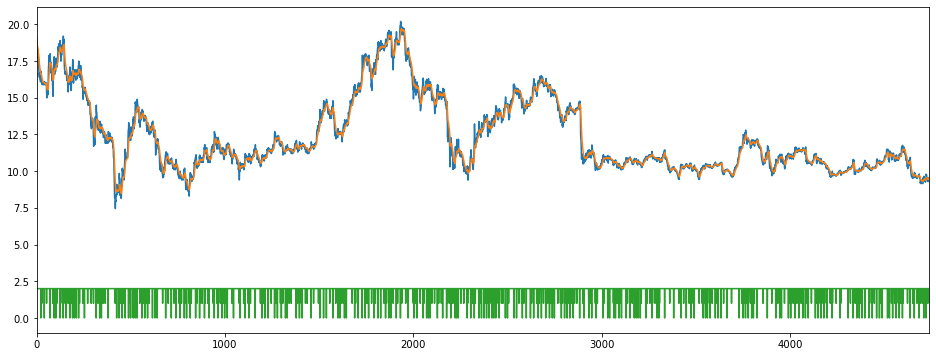

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0

In [8]:
# labels = []
# data_15 = []
# sequential = []
# count = 0

# for i in df.values:
#     if count == 14:
#         x = np.zeros(60)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         for j in range(1,50):
#             x = np.zeros(64)
#             data_15.append(x)
#         labels.append(i[-1])
#         sequential.append(data_15)
#         data_15 = data_15[1:15]
#     else:
#         x = np.zeros(60)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         count+= 1

In [9]:
# labels = []
# data_15 = []
# sequential = []
# count = 0

# for i in df.values:
#     if count == 14:
#         x = np.zeros(11)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         labels.append(i[-1])
#         min_max_scaler = preprocessing.MinMaxScaler()
#         data_15_arr = min_max_scaler.fit_transform(data_15)
#         sequential.append(data_15)
#         data_15 = data_15[1:15]
#     else:
#         x = np.zeros(11)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         count+= 1

In [10]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [11]:
# seq_new = []
# data_15 = []
# for i in range(0,len(sequential)):
#     for j in range(0,len(sequential[i])):
#         x = sequential[i][j]
#         a = np.zeros(11)
#         data_15.append(np.concatenate((x, a)))
        
#     seq_new.append(data_15)
#     data_15 = []

In [12]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [13]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [14]:
X.shape

(4725, 64, 64, 1)

In [15]:
v = X.reshape(X.shape[0],64, 64)
v[0]

array([[1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.75999985, 0.92783951, 0.78504654, ..., 0.        , 0.        ,
        0.        ],
       [0.64000015, 0.8402295 , 0.80601767, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.325581395348837, 1: 7.411764705882353, 2: 0.36649214659685864}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.2972 - accuracy: 0.6953 - mse: 0.4220 - weighted_accuracy: 0.2735 - weighted_mse: 0.4792WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 23ms/step - loss: 0.2186 - accuracy: 0.4439 - mse: 0.9653 - weighted_accuracy: 0.3393 - weighted_mse: 0.9933 - val_loss: 0.1897 - val_accuracy: 0.1746 - val_mse: 1.1758 - val_weighted_accuracy: 0.1746 - val_weighted_mse: 1.1758
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2032 - accuracy: 0.3167 - mse: 1.1564 - weighted_accuracy: 0.3555 - weighted_mse: 1.1692 - val_loss: 0.1928 - val_accuracy: 0.1291 - va

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1740 - accuracy: 0.1770 - mse: 1.4015 - weighted_accuracy: 0.5393 - weighted_mse: 1.3037 - val_loss: 0.2006 - val_accuracy: 0.1556 - val_mse: 1.2211 - val_weighted_accuracy: 0.1556 - val_weighted_mse: 1.2211
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1709 - accuracy: 0.2810 - mse: 1.3922 - weighted_accuracy: 0.5381 - weighted_mse: 1.3441 - val_loss: 0.1972 - val_accuracy: 0.1894 - val_mse: 1.2656 - val_weighted_accuracy: 0.1894 - val_weighted_mse: 1.2656
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1709 - accuracy: 0.1971 - mse: 1.4068 - weighted_accuracy: 0.5613 - weighted_mse: 1.3360 - val_loss: 0.2040 - val_accuracy: 0.1492 - val_mse: 1.2971 - val_weighted_accuracy: 0.1492 - val_weighted_mse: 1.2971
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1690 - accuracy: 0.2405 - mse: 1.4182 - weighted_accuracy: 0.5846 - weig

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1620 - accuracy: 0.2251 - mse: 1.5706 - weighted_accuracy: 0.5866 - weighted_mse: 1.4855 - val_loss: 0.1926 - val_accuracy: 0.2593 - val_mse: 1.4390 - val_weighted_accuracy: 0.2593 - val_weighted_mse: 1.4390
Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1582 - accuracy: 0.2765 - mse: 1.5063 - weighted_accuracy: 0.6220 - weighted_mse: 1.4404 - val_loss: 0.2034 - val_accuracy: 0.2042 - val_mse: 1.5018 - val_weighted_accuracy: 0.2042 - val_weighted_mse: 1.5018
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1601 - accuracy: 0.2442 - mse: 1.5595 - weighted_accuracy: 0.6046 - weighted_mse: 1.4682 - val_loss: 0.2017 - val_accuracy: 0.2233 - val_mse: 1.4732 - val_weighted_accuracy: 0.2233 - val_weighted_mse: 1.4732
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1579 - accuracy: 0.2601 - mse: 1.5181 - weighted_accuracy: 0.6158 - w

Epoch 85/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1507 - accuracy: 0.2778 - mse: 1.6896 - weighted_accuracy: 0.6539 - weighted_mse: 1.6098 - val_loss: 0.2024 - val_accuracy: 0.2413 - val_mse: 1.6434 - val_weighted_accuracy: 0.2413 - val_weighted_mse: 1.6434
Epoch 86/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1506 - accuracy: 0.2905 - mse: 1.6905 - weighted_accuracy: 0.6530 - weighted_mse: 1.6270 - val_loss: 0.1947 - val_accuracy: 0.2794 - val_mse: 1.5896 - val_weighted_accuracy: 0.2794 - val_weighted_mse: 1.5896
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1521 - accuracy: 0.2854 - mse: 1.7034 - weighted_accuracy: 0.6382 - weighted_mse: 1.6231 - val_loss: 0.2003 - val_accuracy: 0.2466 - val_mse: 1.5832 - val_weighted_accuracy: 0.2466 - val_weighted_mse: 1.5832
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1487 - accuracy: 0.3063 - mse: 1.7499 - weighted_accuracy: 0.6532 - weig

Epoch 114/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1433 - accuracy: 0.3323 - mse: 1.8811 - weighted_accuracy: 0.6813 - weighted_mse: 1.8045 - val_loss: 0.1970 - val_accuracy: 0.2868 - val_mse: 1.7603 - val_weighted_accuracy: 0.2868 - val_weighted_mse: 1.7603
Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1432 - accuracy: 0.3283 - mse: 1.8705 - weighted_accuracy: 0.6761 - weighted_mse: 1.7978 - val_loss: 0.1986 - val_accuracy: 0.2825 - val_mse: 1.7740 - val_weighted_accuracy: 0.2825 - val_weighted_mse: 1.7740
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1442 - accuracy: 0.3241 - mse: 1.8215 - weighted_accuracy: 0.6616 - weighted_mse: 1.7788 - val_loss: 0.2061 - val_accuracy: 0.2466 - val_mse: 1.7186 - val_weighted_accuracy: 0.2466 - val_weighted_mse: 1.7186
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1444 - accuracy: 0.3130 - mse: 1.8202 - weighted_accuracy: 0.6650 - 

Epoch 143/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1386 - accuracy: 0.3598 - mse: 1.9935 - weighted_accuracy: 0.6988 - weighted_mse: 1.9765 - val_loss: 0.2054 - val_accuracy: 0.2963 - val_mse: 1.9443 - val_weighted_accuracy: 0.2963 - val_weighted_mse: 1.9443
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1370 - accuracy: 0.3701 - mse: 1.9930 - weighted_accuracy: 0.6951 - weighted_mse: 1.9819 - val_loss: 0.1965 - val_accuracy: 0.3270 - val_mse: 1.8710 - val_weighted_accuracy: 0.3270 - val_weighted_mse: 1.8710
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1337 - accuracy: 0.3759 - mse: 1.9498 - weighted_accuracy: 0.7231 - weighted_mse: 1.9711 - val_loss: 0.1969 - val_accuracy: 0.3249 - val_mse: 1.9530 - val_weighted_accuracy: 0.3249 - val_weighted_mse: 1.9530
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1351 - accuracy: 0.3984 - mse: 2.0151 - weighted_accuracy: 0.7073 - 

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1285 - accuracy: 0.4159 - mse: 2.1088 - weighted_accuracy: 0.7323 - weighted_mse: 2.2460 - val_loss: 0.1882 - val_accuracy: 0.3926 - val_mse: 2.1117 - val_weighted_accuracy: 0.3926 - val_weighted_mse: 2.1117
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1313 - accuracy: 0.4249 - mse: 2.1750 - weighted_accuracy: 0.7264 - weighted_mse: 2.2327 - val_loss: 0.1916 - val_accuracy: 0.3513 - val_mse: 1.9711 - val_weighted_accuracy: 0.3513 - val_weighted_mse: 1.9711
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1276 - accuracy: 0.4024 - mse: 2.2051 - weighted_accuracy: 0.7273 - weighted_mse: 2.2890 - val_loss: 0.1894 - val_accuracy: 0.3915 - val_mse: 2.1952 - val_weighted_accuracy: 0.3915 - val_weighted_mse: 2.1952
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1268 - accuracy: 0.4519 - mse: 2.1730 - weighted_accuracy: 0.7436 - 

In [21]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18632835149765015
Test accuracy: 0.4402116537094116


In [22]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.15814453 -3.0510373  -0.83426964]
 [-1.5567018  -0.61205524 -0.35176194]
 [-2.1886735   0.1249463  -0.8096591 ]
 ...
 [-1.4060148  -1.570182   -0.10829951]
 [-1.1423095  -1.300886   -0.25995654]
 [-1.702125   -0.79353434 -0.20061943]]


Counter({0: 243, 2: 410, 1: 292})

In [23]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [24]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 945
actual predicted buys: 23
actual buys but predicted sell: 4
actual buys but predicted hold: 16
actual sells but predicted buy: 2
actual predicted sells: 20
actual sells but predicted hold: 21
actual holds but predicted buy: 267
actual holds but predicted sell: 219
actual predicted holds: 373
Percentage buys correct: 53.48837209302326%
Percentage sells correct: 46.51162790697674%
Percentage holds correct: 43.42258440046566%
actual buys: 43
actual sells: 43
actual holds: 859


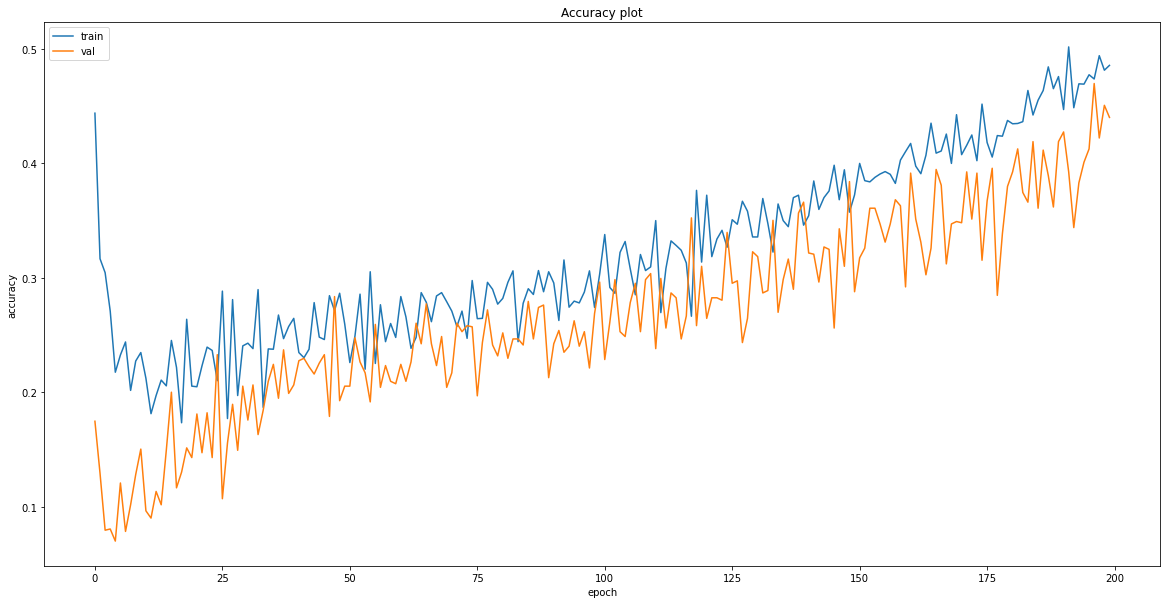

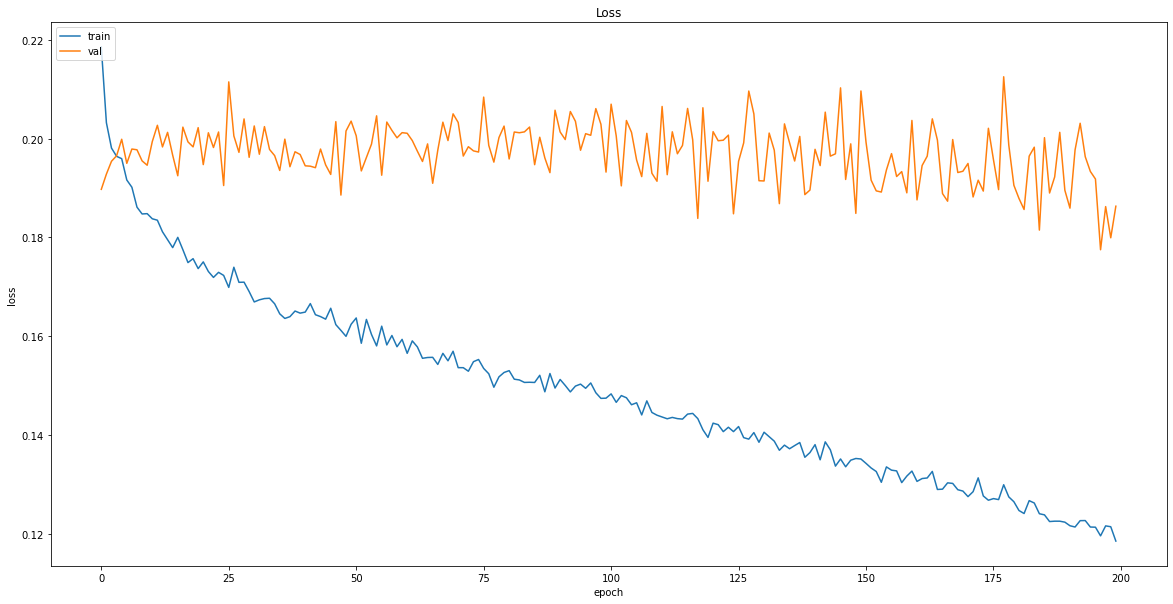

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_cnn_buy_hold_sell_original.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_cnn_buy_hold_sell_original.model\assets


### Test Performance

#### Non-recession

In [27]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
1  2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2  2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
3  2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
4  2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


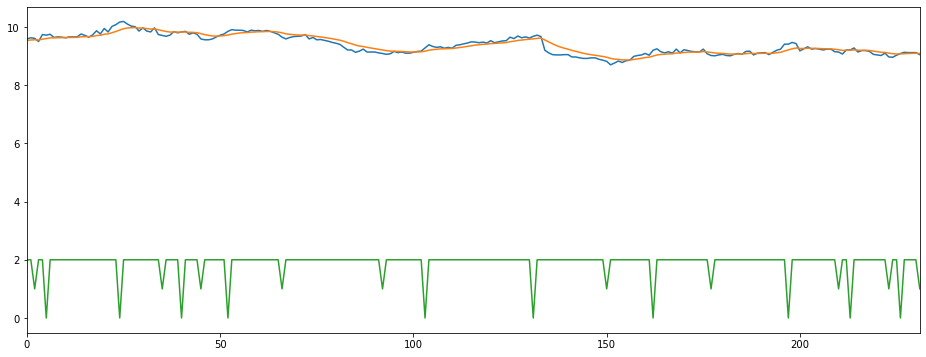

In [28]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [29]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0

In [30]:
# labels = []
# data_15 = []
# sequential = []
# count = 0

# for i in df.values:
#     if count == 14:
#         x = np.zeros(11)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         labels.append(i[-1])
#         sequential.append(data_15)
#         data_15 = data_15[1:15]
#     else:
#         x = np.zeros(11)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         count+= 1

In [31]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [32]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [33]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [34]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [35]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1724 - accuracy: 0.4725 - mean_squared_error: 2.2194 - weighted_accuracy: 0.4725 - weighted_mean_squared_error: 2.2194
Test loss: 0.17239275574684143
Test accuracy: 0.4724770784378052


In [36]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 54, 2: 91, 1: 73})

In [37]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [38]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [39]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2019-02-08         9.76  9.644474 -45.454598  5084100.0     2.0            0   
2019-02-11         9.71  9.662247 -15.151533  6464788.0     2.0            2   
2019-02-12         9.65  9.669594 -30.303065  5675088.0     2.0            2   
2019-02-13         9.73  9.666579 -48.484962  4337188.0     2.0            0   
2019-02-14         9.87  9.676336 -32.000351  5826588.0     2.0            0   

            actual  
Date                
2019-02-08       2  
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2

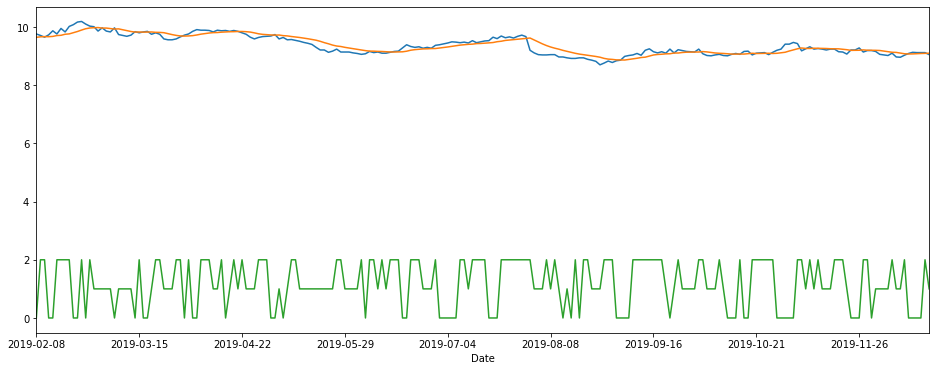

In [40]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

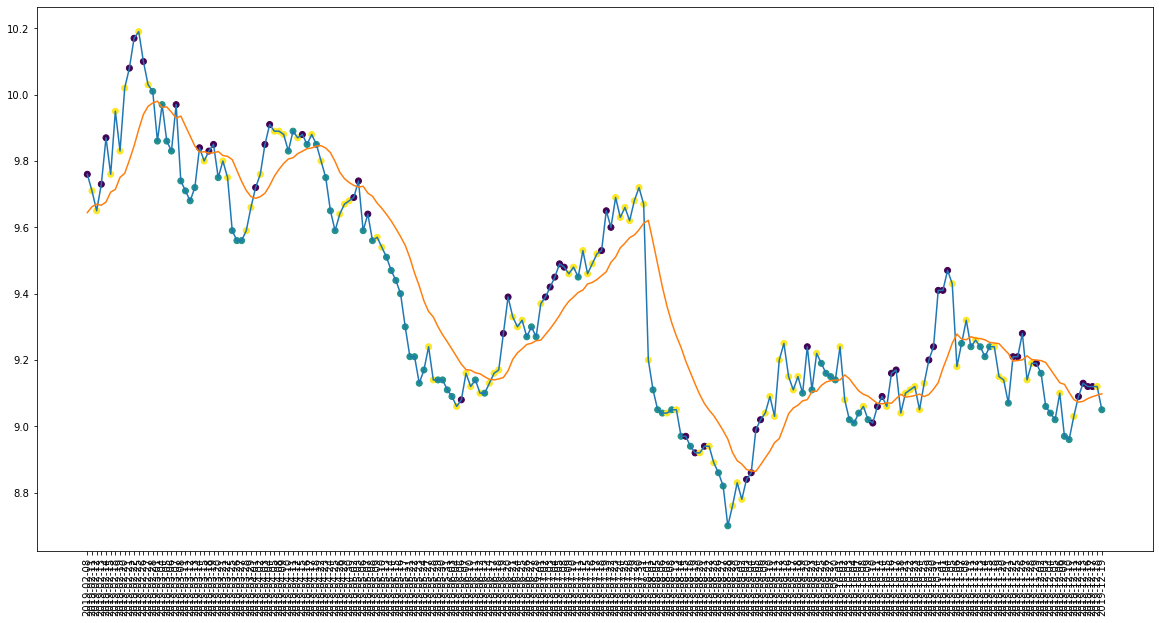

In [41]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [42]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 65
actual holds but predicted sell: 47
actual predicted holds: 88
Percentage buys correct: 88.88888888888889%
Percentage sells correct: 77.77777777777777%
Percentage holds correct: 44.0%
actual buys: 9
actual sells: 9
actual holds: 200


In [43]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672]
[9.829999923706056, 9.949999809265137, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 68.4931506849315%
Percentage sells correct: 62.96296296296296%
Percentage holds correct: 84.61538461538461%


In [44]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.010000228881836
Shares owned at the moment: 996
Cash capital at the moment: $2.622381406783461


Stop Loss Activated!

Share price: $9.710000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9647.186729296684


Share price: $9.710000038146973
Shares owned at the moment: 990
Cash capital at the moment: $7.851216427325198


Stop Loss Activated!

Share price: $9.4399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9327.750402149199


Share price: $9.4399995803833
Shares owned at the moment: 985
Cash capital at the moment: $3.7802166082838085


Stop Loss Activated!

Share price: $9.130000114440918
Shares owned at the moment: 0
Cash capital at the moment: $8972.099441522596


Share price: $9.130000114440918
Shares owned at the moment: 980
Cash capital at the moment: $0.09397906207777851


Price increase from previously bought: 5.405638301585958%
Share price: $9.649999618530273
Shares owned at the moment: 0
Cash capital at the moment: $

In [45]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9222.27618237376
profit gained: -7.777238176262399%


#### Recession

In [46]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


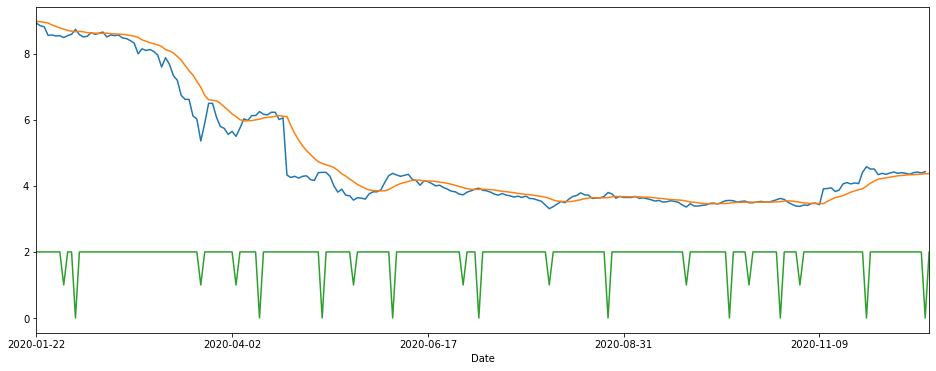

In [47]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [48]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [49]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [50]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [51]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [52]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1878 - accuracy: 0.4186 - mean_squared_error: 2.3951 - weighted_accuracy: 0.4186 - weighted_mean_squared_error: 2.3951
Test loss: 0.18775716423988342
Test accuracy: 0.41860464215278625


In [53]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 87, 0: 31, 1: 97})

In [54]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 198, 1: 8, 0: 9})

In [55]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


In [56]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-11         8.53  8.641035 -89.830440 -3476200.0     2.0            2   
2020-02-12         8.64  8.623953 -86.440694 -2356000.0     2.0            2   
2020-02-13         8.59  8.626421 -61.224363  -575600.0     2.0            2   
2020-02-14         8.62  8.620818 -64.102508 -2132700.0     2.0            2   
2020-02-17         8.66  8.620692 -45.161340  -798700.0     2.0            0   

            actual  
Date                
2020-02-11       2  
2020-02-12       2  
2020-02-13       2  
2020-02-14       2  
2020-02-17       2

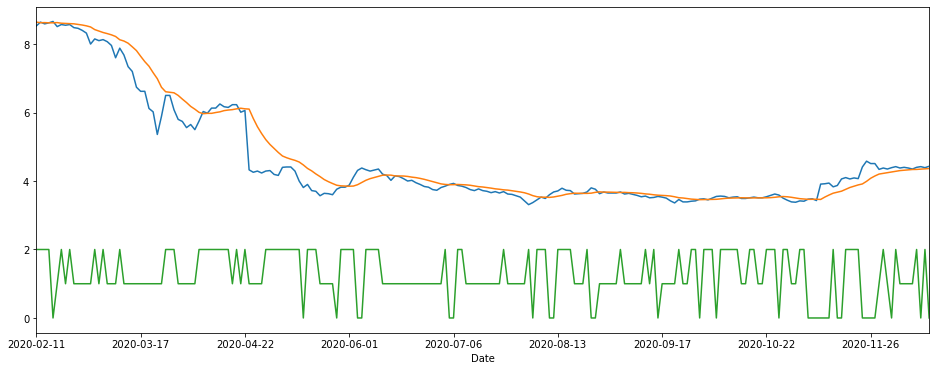

In [57]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

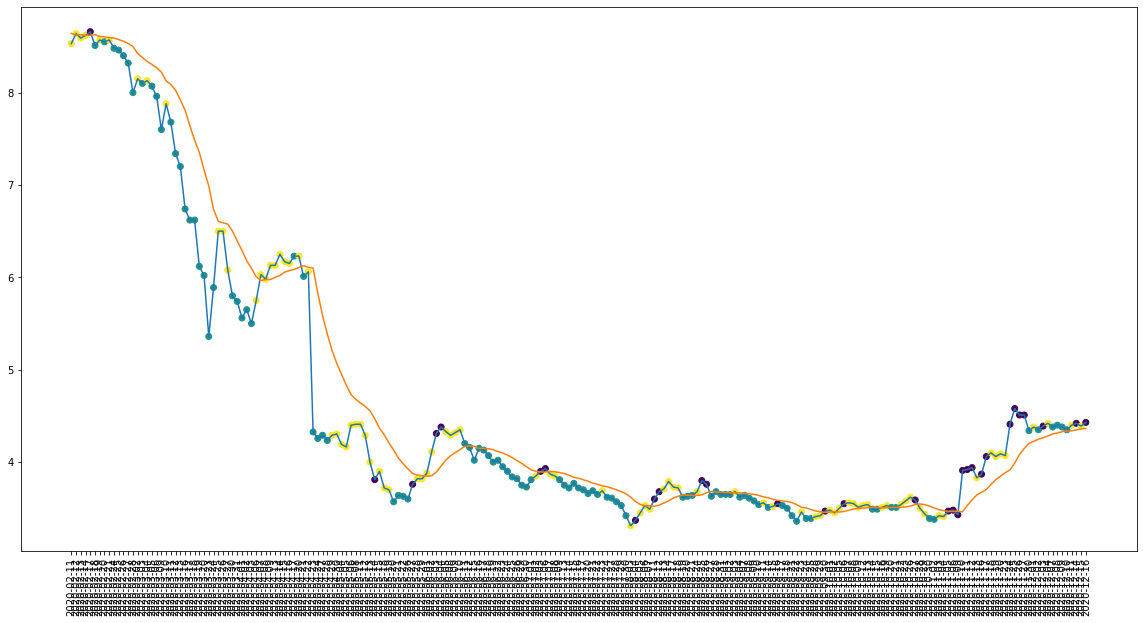

In [58]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [59]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 91
actual holds but predicted sell: 27
actual predicted holds: 80
Percentage buys correct: 75.0%
Percentage sells correct: 44.44444444444444%
Percentage holds correct: 40.4040404040404%
actual buys: 8
actual sells: 9
actual holds: 198


In [60]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.510000228881836, 8.529999732971191, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219, 8.569999694824219]
Percentage buys correct: 56.70103092783505%
Percentage sells correct: 77.41935483870968%
Percentage holds correct: 86.20689655172414%


In [61]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.510000228881836
Shares owned at the moment: 1171
Cash capital at the moment: $7.385403742313429


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9349.623403742313


Share price: $8.0
Shares owned at the moment: 1165
Cash capital at the moment: $3.9934037423117843


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $8833.644792944786


Share price: $7.599999904632567
Shares owned at the moment: 1159
Cash capital at the moment: $1.0218037796003046


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8484.68756514263


Share price: $7.3400001525878915
Shares owned at the moment: 1152
Cash capital at the moment: $5.754268877979484


Stop Loss Activated!

Share price: $6.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $7748.881685931202


Share price: $6.739999771118164
Share

In [62]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5165.4369528948055
profit gained: -48.34563047105195%


### OCBC 

In [63]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


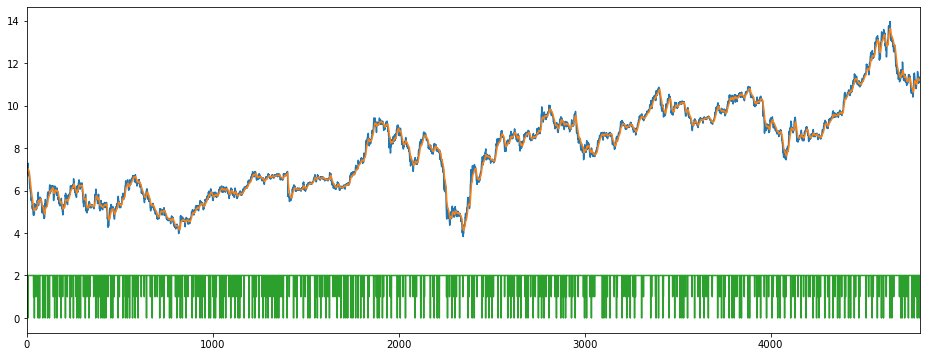

In [64]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [65]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0

In [66]:
# labels = []
# data_15 = []
# sequential = []
# count = 0

# for i in df.values:
#     if count == 14:
#         x = np.zeros(11)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         labels.append(i[-1])
#         sequential.append(data_15)
#         data_15 = data_15[1:15]
#     else:
#         x = np.zeros(11)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         count+= 1

In [67]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [68]:
# seq_new = []
# data_15 = []
# for i in range(0,len(sequential)):
#     for j in range(0,len(sequential[i])):
#         x = sequential[i][j]
#         a = np.zeros(11)
#         data_15.append(np.concatenate((x, a)))
        
#     seq_new.append(data_15)
#     data_15 = []

In [69]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [70]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [71]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [72]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [73]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [75]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
    
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

#Scaling by total/3 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / sell)*(total)/3.0 
# weight_for_1 = (1 / buy)*(total)/3.0
# weight_for_2 = (1 / hold)*(total)/3.0

# d_class_weights = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))
# print('Weight for class 2: {:.2f}'.format(weight_for_2))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.255681818181818, 1: 7.931677018633541, 2: 0.3654836863194047}
Epoch 1/200
30/30 [==============================] - 2s 79ms/step - loss: 0.2169 - accuracy: 0.3892 - mse: 0.9855 - weighted_accuracy: 0.3428 - weighted_mse: 1.0254 - val_loss: 0.1925 - val_accuracy: 0.1576 - val_mse: 1.1349 - val_weighted_accuracy: 0.1576 - val_weighted_mse: 1.1349
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2008 - accuracy: 0.3125 - mse: 1.1449 - weighted_accuracy: 0.3897 - weighted_mse: 1.1410 - val_loss: 0.1920 - val_accuracy: 0.1514 - val_mse: 1.1443 - val_weighted_accuracy: 0.1514 - val_weighted_mse: 1.1443
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1992 - accuracy: 0.3279 - mse: 1.1764 - weighted_accuracy: 0.4204 - weighted_mse: 1.1774 - val_loss: 0.1923 - val_accuracy: 0.1775 - val_mse: 1.0742 - val_weighted_accuracy: 0.1775 - val_weighted_mse: 1.0742
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1958 - 

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1521 - accuracy: 0.2425 - mse: 1.7736 - weighted_accuracy: 0.6315 - weighted_mse: 1.6726 - val_loss: 0.2029 - val_accuracy: 0.2098 - val_mse: 1.6703 - val_weighted_accuracy: 0.2098 - val_weighted_mse: 1.6703
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1508 - accuracy: 0.2655 - mse: 1.7425 - weighted_accuracy: 0.6614 - weighted_mse: 1.6832 - val_loss: 0.2028 - val_accuracy: 0.2129 - val_mse: 1.7324 - val_weighted_accuracy: 0.2129 - val_weighted_mse: 1.7324
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1530 - accuracy: 0.2446 - mse: 1.8076 - weighted_accuracy: 0.6493 - weighted_mse: 1.7029 - val_loss: 0.2050 - val_accuracy: 0.2234 - val_mse: 1.6560 - val_weighted_accuracy: 0.2234 - val_weighted_mse: 1.6560
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1506 - accuracy: 0.2540 - mse: 1.7912 - weighted_accuracy: 0.6436 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1428 - accuracy: 0.2884 - mse: 1.9783 - weighted_accuracy: 0.6835 - weighted_mse: 1.8866 - val_loss: 0.2034 - val_accuracy: 0.2537 - val_mse: 1.9317 - val_weighted_accuracy: 0.2537 - val_weighted_mse: 1.9317
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1440 - accuracy: 0.3218 - mse: 1.9900 - weighted_accuracy: 0.6759 - weighted_mse: 1.9373 - val_loss: 0.2029 - val_accuracy: 0.2307 - val_mse: 1.7881 - val_weighted_accuracy: 0.2307 - val_weighted_mse: 1.7881
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1429 - accuracy: 0.2561 - mse: 1.9886 - weighted_accuracy: 0.6819 - weighted_mse: 1.9030 - val_loss: 0.1992 - val_accuracy: 0.2537 - val_mse: 1.8949 - val_weighted_accuracy: 0.2537 - val_weighted_mse: 1.8949
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1431 - accuracy: 0.2931 - mse: 1.9978 - weighted_accuracy: 0.6856 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1365 - accuracy: 0.3754 - mse: 2.1021 - weighted_accuracy: 0.7030 - weighted_mse: 2.0779 - val_loss: 0.2003 - val_accuracy: 0.2923 - val_mse: 2.1407 - val_weighted_accuracy: 0.2923 - val_weighted_mse: 2.1407
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1364 - accuracy: 0.3425 - mse: 2.2430 - weighted_accuracy: 0.7167 - weighted_mse: 2.2214 - val_loss: 0.1847 - val_accuracy: 0.3476 - val_mse: 2.0311 - val_weighted_accuracy: 0.3476 - val_weighted_mse: 2.0311
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1371 - accuracy: 0.3466 - mse: 2.1155 - weighted_accuracy: 0.6992 - weighted_mse: 2.0496 - val_loss: 0.1904 - val_accuracy: 0.3340 - val_mse: 2.0209 - val_weighted_accuracy: 0.3340 - val_weighted_mse: 2.0209
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1346 - accuracy: 0.3704 - mse: 2.1546 - weighted_accuracy: 0.7161 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1273 - accuracy: 0.4234 - mse: 2.4679 - weighted_accuracy: 0.7316 - weighted_mse: 2.4934 - val_loss: 0.1935 - val_accuracy: 0.3351 - val_mse: 2.2719 - val_weighted_accuracy: 0.3351 - val_weighted_mse: 2.2719
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1305 - accuracy: 0.4064 - mse: 2.3245 - weighted_accuracy: 0.7365 - weighted_mse: 2.2870 - val_loss: 0.2131 - val_accuracy: 0.2860 - val_mse: 2.3270 - val_weighted_accuracy: 0.2860 - val_weighted_mse: 2.3270
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1297 - accuracy: 0.4067 - mse: 2.4367 - weighted_accuracy: 0.7299 - weighted_mse: 2.4255 - val_loss: 0.1984 - val_accuracy: 0.3152 - val_mse: 2.2760 - val_weighted_accuracy: 0.3152 - val_weighted_mse: 2.2760
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1274 - accuracy: 0.3965 - mse: 2.4346 - weighted_accuracy: 0.7350 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1209 - accuracy: 0.4547 - mse: 2.6751 - weighted_accuracy: 0.7612 - weighted_mse: 2.7115 - val_loss: 0.1871 - val_accuracy: 0.3841 - val_mse: 2.5540 - val_weighted_accuracy: 0.3841 - val_weighted_mse: 2.5540
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1199 - accuracy: 0.4792 - mse: 2.6985 - weighted_accuracy: 0.7651 - weighted_mse: 2.7665 - val_loss: 0.1864 - val_accuracy: 0.3987 - val_mse: 2.5165 - val_weighted_accuracy: 0.3987 - val_weighted_mse: 2.5165
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1189 - accuracy: 0.4605 - mse: 2.6586 - weighted_accuracy: 0.7633 - weighted_mse: 2.7934 - val_loss: 0.1898 - val_accuracy: 0.3956 - val_mse: 2.5770 - val_weighted_accuracy: 0.3956 - val_weighted_mse: 2.5770
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1198 - accuracy: 0.4706 - mse: 2.7389 - weighted_accuracy: 0.7652 - 

In [76]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18268704414367676
Test accuracy: 0.45093944668769836


In [77]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.0280122  -3.4731686  -0.5670226 ]
 [-2.7490962   0.32351467 -0.9712699 ]
 [-1.2724413  -1.1773154  -0.03065234]
 ...
 [-2.624733   -0.8053318  -0.07772785]
 [ 0.16648163 -2.1929245  -0.7272019 ]
 [-0.39473683 -1.5687972  -0.8434591 ]]


Counter({0: 267, 1: 258, 2: 433})

In [78]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [79]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 958
actual predicted buys: 17
actual buys but predicted sell: 0
actual buys but predicted hold: 23
actual sells but predicted buy: 3
actual predicted sells: 23
actual sells but predicted hold: 18
actual holds but predicted buy: 238
actual holds but predicted sell: 244
actual predicted holds: 392
Percentage buys correct: 42.5%
Percentage sells correct: 52.27272727272727%
Percentage holds correct: 44.8512585812357%
actual buys: 40
actual sells: 44
actual holds: 874


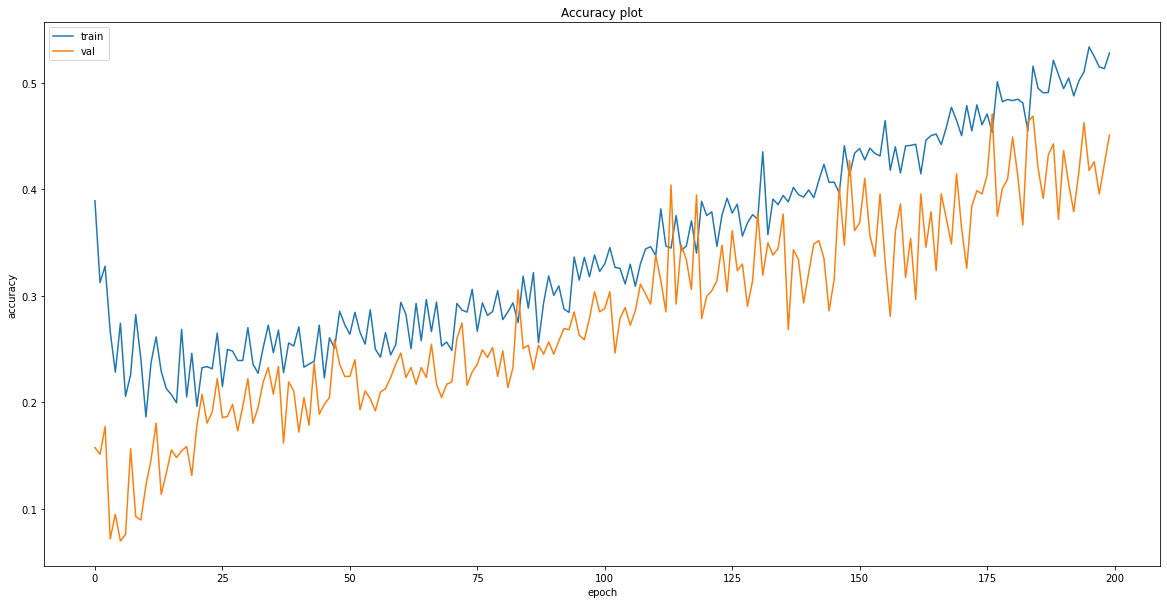

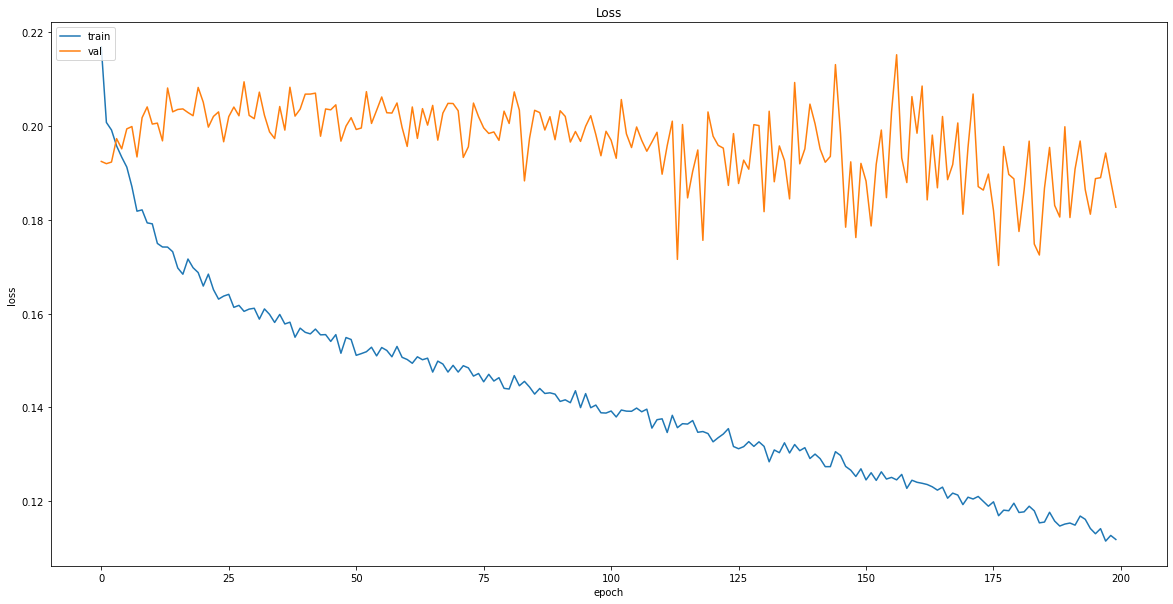

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [81]:
# Save model
model.save("models/{}".format('OCBC_time_series_cnn_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/OCBC_time_series_cnn_buy_hold_sell_original.model\assets


### Test Performance

#### Non-Recession

In [82]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
1  2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2  2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
3  2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
4  2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


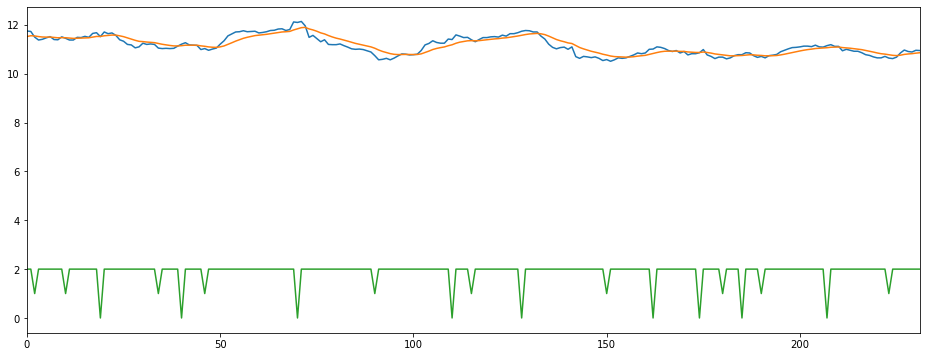

In [83]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [84]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0

In [85]:
# labels = []
# data_15 = []
# sequential = []
# count = 0

# for i in df.values:
#     if count == 14:
#         x = np.zeros(11)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         labels.append(i[-1])
#         sequential.append(data_15)
#         data_15 = data_15[1:15]
#     else:
#         x = np.zeros(11)
#         arr = np.concatenate((i[0:-1], x))
#         data_15.append(arr)
#         count+= 1

In [86]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [87]:
# seq_new = []
# data_15 = []
# for i in range(0,len(sequential)):
#     for j in range(0,len(sequential[i])):
#         x = sequential[i][j]
#         a = np.zeros(11)
#         data_15.append(np.concatenate((x, a)))
        
#     seq_new.append(data_15)
#     data_15 = []

In [88]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [89]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [90]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [91]:
model = tf.keras.models.load_model("models/OCBC_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 0.4495 - mean_squared_error: 2.8385 - weighted_accuracy: 0.4495 - weighted_mean_squared_error: 2.8385
Test loss: 0.18173037469387054
Test accuracy: 0.44954127073287964


In [92]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 93, 0: 61, 1: 64})

In [93]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [94]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


In [95]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-08        11.48  11.453417 -66.071471  20418651.0     2.0   
2019-02-11        11.53  11.457507 -67.857228  17615658.0     2.0   
2019-02-12        11.49  11.468659 -43.902530  20832858.0     2.0   
2019-02-13        11.65  11.471942 -42.424356  17325458.0     2.0   
2019-02-14        11.68  11.499336 -10.256417  22091358.0     2.0   

            predictions  actual  
Date                             
2019-02-08            2       2  
2019-02-11            0       2  
2019-02-12            0       2  
2019-02-13            0       2  
2019-02-14            2       2

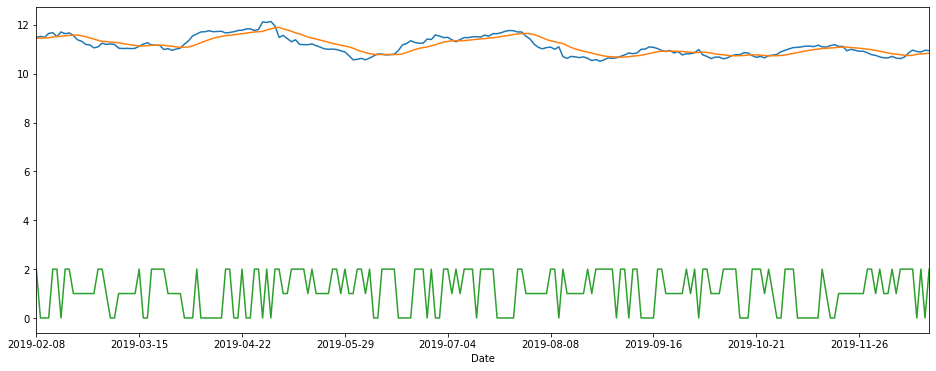

In [96]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

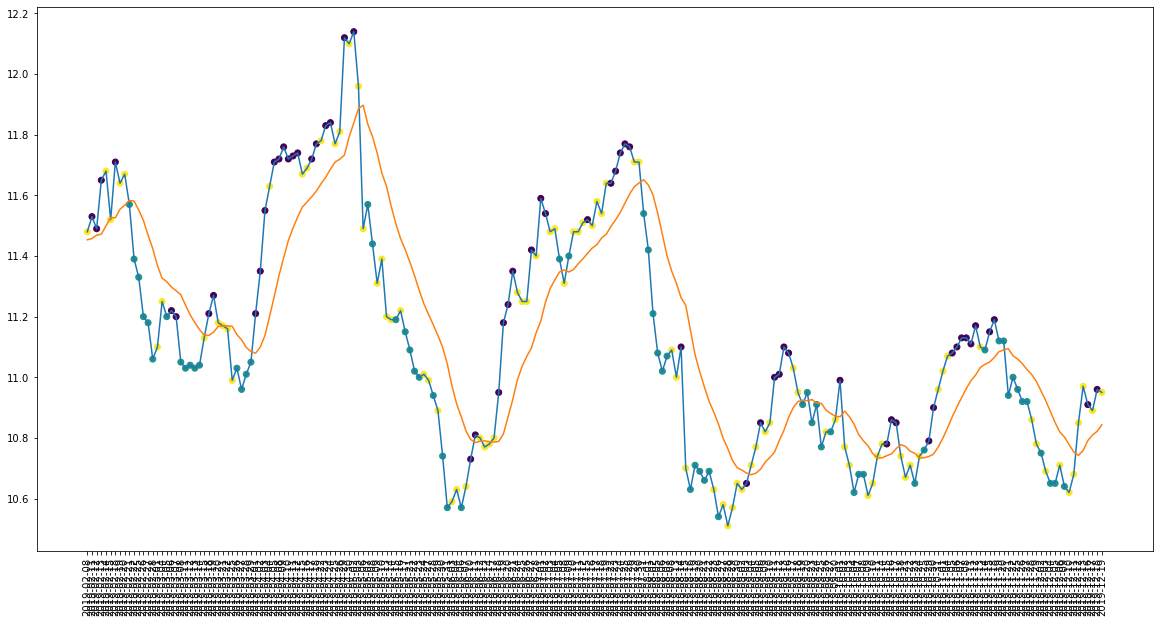

In [97]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [98]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 58
actual holds but predicted sell: 56
actual predicted holds: 87
Percentage buys correct: 75.0%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 43.28358208955224%
actual buys: 8
actual sells: 9
actual holds: 201


In [99]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.479999542236328, 11.489999771118164, 11.520000457763672, 11.529999732971193, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945, 11.710000038146973]
Percentage buys correct: 54.6875%
Percentage sells correct: 67.21311475409836%
Percentage holds correct: 90.3225806451613%


In [100]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.56999969482422
Shares owned at the moment: 861
Cash capital at the moment: $10.83539597892559


Stop Loss Activated!

Share price: $11.199999809265137
Shares owned at the moment: 0
Cash capital at the moment: $9627.51643220782


Share price: $11.199999809265137
Shares owned at the moment: 857
Cash capital at the moment: $2.7209961171120085


Price increase from previously bought: 5.335328962939023%
Share price: $11.829999923706055
Shares owned at the moment: 0
Cash capital at the moment: $10113.150578413006


Share price: $11.56999969482422
Shares owned at the moment: 871
Cash capital at the moment: $7.967802452081742


Stop Loss Activated!

Share price: $11.199999809265137
Shares owned at the moment: 0
Cash capital at the moment: $9736.340836778872


Share price: $11.1899995803833
Shares owned at the moment: 867
Cash capital at the moment: $7.931444087022101


Stop Loss Activated!

Share price: $10.739999771118164
Shares owned at the moment: 0
Cash capital at the mome

In [101]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9486.419823328972
profit gained: -5.135801766710283%


#### Recession

In [102]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


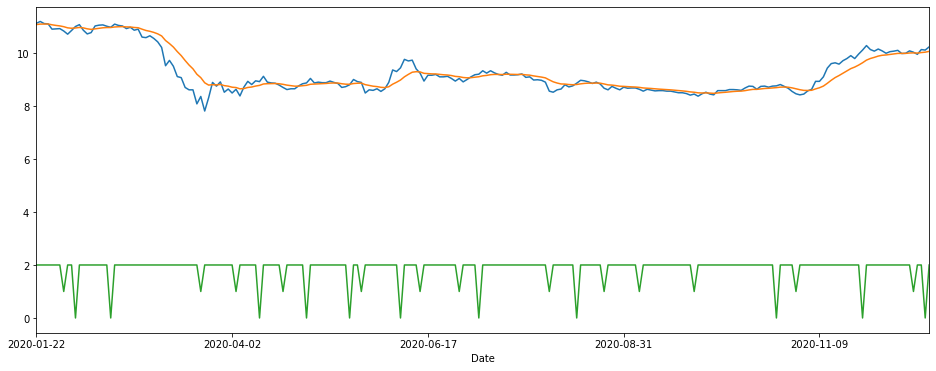

In [103]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [104]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [105]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [106]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [107]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [108]:
model = tf.keras.models.load_model("models/OCBC_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1793 - accuracy: 0.5163 - mean_squared_error: 2.9627 - weighted_accuracy: 0.5163 - weighted_mean_squared_error: 2.9627
Test loss: 0.1793069839477539
Test accuracy: 0.5162790417671204


In [109]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 109, 1: 69, 0: 37})

In [110]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [111]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [112]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-11        10.77  10.912571 -89.285647   9290100.0     2.0   
2020-02-12        11.02  10.890637 -80.357049  13333200.0     2.0   
2020-02-13        11.05  10.910539 -32.075322  21593100.0     2.0   
2020-02-14        11.06  10.931995 -15.217324  25962500.0     2.0   
2020-02-17        11.01  10.951688 -13.043361  29610200.0     2.0   

            predictions  actual  
Date                             
2020-02-11            2       2  
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            2       2

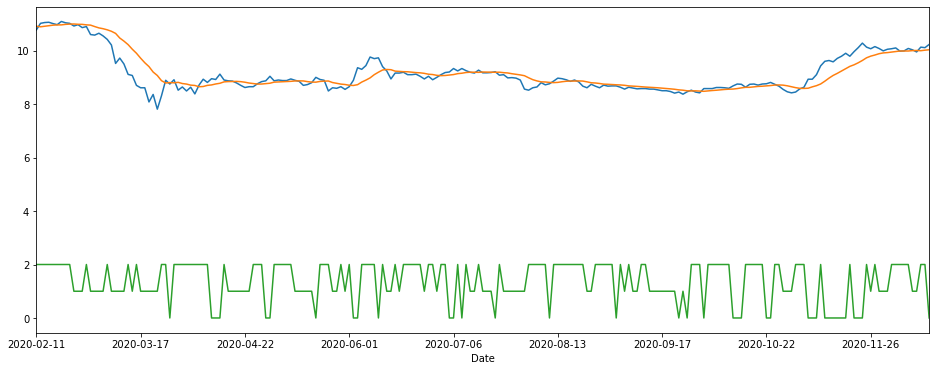

In [113]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

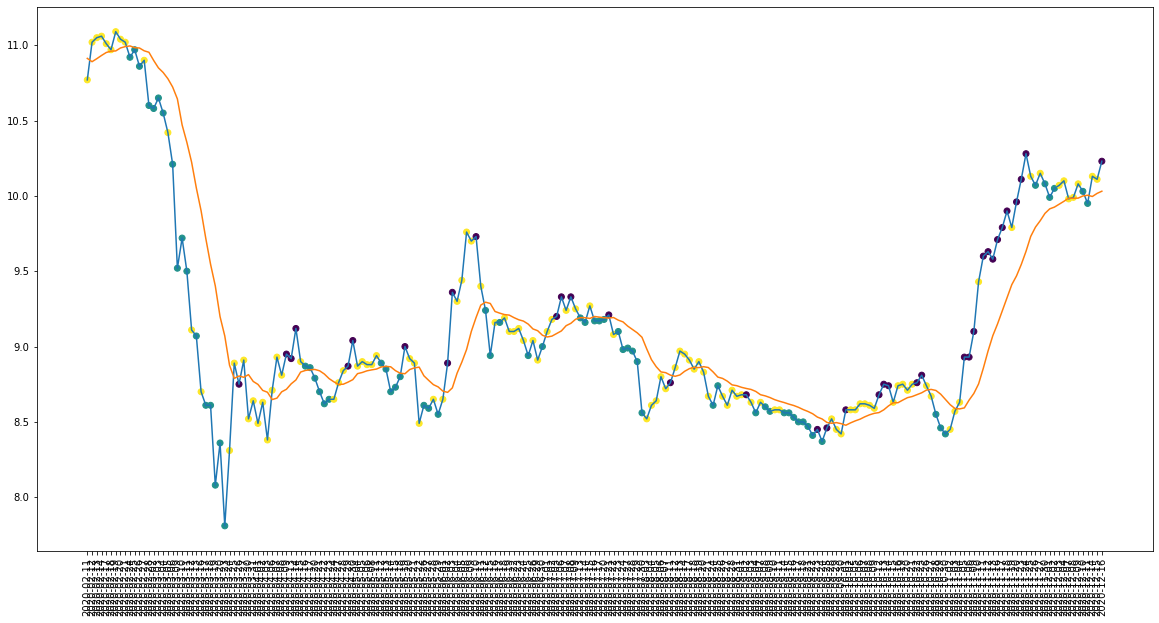

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [115]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 62
actual holds but predicted sell: 31
actual predicted holds: 100
Percentage buys correct: 50.0%
Percentage sells correct: 50.0%
Percentage holds correct: 51.81347150259067%
actual buys: 12
actual sells: 10
actual holds: 193


In [116]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.770000457763672, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027, 11.09000015258789]
Percentage buys correct: 62.31884057971015%
Percentage sells correct: 75.67567567567568%
Percentage holds correct: 88.9908256880734%


In [117]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.920000076293944
Shares owned at the moment: 913
Cash capital at the moment: $2.6225401520750893


Stop Loss Activated!

Share price: $10.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9653.80893747616


Share price: $10.600000381469727
Shares owned at the moment: 908
Cash capital at the moment: $2.540390149119048


Stop Loss Activated!

Share price: $10.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9247.726054691317


Share price: $10.210000038146973
Shares owned at the moment: 903
Cash capital at the moment: $2.7420376498721453


Stop Loss Activated!

Share price: $9.520000457763672
Shares owned at the moment: 0
Cash capital at the moment: $8575.661909873726


Share price: $9.520000457763672
Shares owned at the moment: 898
Cash capital at the moment: $3.191857671501566


Stop Loss Activated!

Share price: $9.109999656677246
Shares owned at the moment: 0
Cash capital at the moment: $8161.474405215504


Share pric

In [118]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9447.080403137206
profit gained: -5.529195968627937%


## CNOOC Limited

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


In [6]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0

In [7]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [8]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [9]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [10]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [11]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [12]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.252525252525253, 1: 7.364102564102564, 2: 0.36679438058748404}
Epoch 1/200
 1/23 [>.............................] - ETA: 0s - loss: 0.2645 - accuracy: 0.7031 - mse: 0.4220 - weighted_accuracy: 0.3069 - weighted_mse: 0.4616WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
23/23 [==============================] - 1s 26ms/step - loss: 0.2254 - accuracy: 0.4265 - mse: 0.8833 - weighted_accuracy: 0.3000 - weighted_mse: 0.9221 - val_loss: 0.1887 - val_accuracy: 0.1323 - val_mse: 1.1527 - val_weighted_accuracy: 0.1323 - val_weighted_mse: 1.1527
Epoch 2/200
23/23 [==============================] - 0s 9ms/step - loss: 0.2023 - accuracy: 0.4029 - mse: 1.1942 - weighted_accuracy: 0.3653 - weighted_mse: 1.2057 - val_loss: 0.1870 - val_accuracy: 0.5780 - va

Epoch 27/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1645 - accuracy: 0.2695 - mse: 1.4566 - weighted_accuracy: 0.6116 - weighted_mse: 1.3684 - val_loss: 0.1947 - val_accuracy: 0.2396 - val_mse: 1.3714 - val_weighted_accuracy: 0.2396 - val_weighted_mse: 1.3714
Epoch 28/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1651 - accuracy: 0.3022 - mse: 1.4553 - weighted_accuracy: 0.5993 - weighted_mse: 1.3566 - val_loss: 0.1905 - val_accuracy: 0.2660 - val_mse: 1.3237 - val_weighted_accuracy: 0.2660 - val_weighted_mse: 1.3237
Epoch 29/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1684 - accuracy: 0.2604 - mse: 1.4427 - weighted_accuracy: 0.5623 - weighted_mse: 1.3514 - val_loss: 0.2101 - val_accuracy: 0.1546 - val_mse: 1.3284 - val_weighted_accuracy: 0.1546 - val_weighted_mse: 1.3284
Epoch 30/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1661 - accuracy: 0.2176 - mse: 1.4796 - weighted_accuracy: 0.6189 - weig

Epoch 56/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1574 - accuracy: 0.2733 - mse: 1.6350 - weighted_accuracy: 0.6153 - weighted_mse: 1.5376 - val_loss: 0.1964 - val_accuracy: 0.2507 - val_mse: 1.5610 - val_weighted_accuracy: 0.2507 - val_weighted_mse: 1.5610
Epoch 57/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1532 - accuracy: 0.2859 - mse: 1.6523 - weighted_accuracy: 0.6297 - weighted_mse: 1.5665 - val_loss: 0.2027 - val_accuracy: 0.2131 - val_mse: 1.5816 - val_weighted_accuracy: 0.2131 - val_weighted_mse: 1.5816
Epoch 58/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1521 - accuracy: 0.2893 - mse: 1.6569 - weighted_accuracy: 0.6429 - weighted_mse: 1.5908 - val_loss: 0.2010 - val_accuracy: 0.2493 - val_mse: 1.5446 - val_weighted_accuracy: 0.2493 - val_weighted_mse: 1.5446
Epoch 59/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1531 - accuracy: 0.2786 - mse: 1.7005 - weighted_accuracy: 0.6294 - weig

Epoch 85/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1464 - accuracy: 0.3235 - mse: 1.7533 - weighted_accuracy: 0.6674 - weighted_mse: 1.6879 - val_loss: 0.2067 - val_accuracy: 0.2340 - val_mse: 1.7052 - val_weighted_accuracy: 0.2340 - val_weighted_mse: 1.7052
Epoch 86/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1471 - accuracy: 0.2914 - mse: 1.8416 - weighted_accuracy: 0.6604 - weighted_mse: 1.7563 - val_loss: 0.1984 - val_accuracy: 0.2799 - val_mse: 1.7225 - val_weighted_accuracy: 0.2799 - val_weighted_mse: 1.7225
Epoch 87/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1441 - accuracy: 0.3175 - mse: 1.8396 - weighted_accuracy: 0.6677 - weighted_mse: 1.7766 - val_loss: 0.1995 - val_accuracy: 0.2799 - val_mse: 1.7567 - val_weighted_accuracy: 0.2799 - val_weighted_mse: 1.7567
Epoch 88/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1457 - accuracy: 0.3088 - mse: 1.8365 - weighted_accuracy: 0.6669 - weig

Epoch 114/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1406 - accuracy: 0.3099 - mse: 1.9538 - weighted_accuracy: 0.7083 - weighted_mse: 1.9004 - val_loss: 0.1940 - val_accuracy: 0.3078 - val_mse: 1.8073 - val_weighted_accuracy: 0.3078 - val_weighted_mse: 1.8073
Epoch 115/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1405 - accuracy: 0.3405 - mse: 1.9610 - weighted_accuracy: 0.7003 - weighted_mse: 1.9039 - val_loss: 0.1954 - val_accuracy: 0.3050 - val_mse: 1.8859 - val_weighted_accuracy: 0.3050 - val_weighted_mse: 1.8859
Epoch 116/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1389 - accuracy: 0.3712 - mse: 1.9390 - weighted_accuracy: 0.6872 - weighted_mse: 1.9211 - val_loss: 0.1963 - val_accuracy: 0.3217 - val_mse: 1.8587 - val_weighted_accuracy: 0.3217 - val_weighted_mse: 1.8587
Epoch 117/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1401 - accuracy: 0.3064 - mse: 2.0017 - weighted_accuracy: 0.6926 -

Epoch 143/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1333 - accuracy: 0.3990 - mse: 2.0875 - weighted_accuracy: 0.7096 - weighted_mse: 2.1143 - val_loss: 0.2035 - val_accuracy: 0.2967 - val_mse: 2.0444 - val_weighted_accuracy: 0.2967 - val_weighted_mse: 2.0444
Epoch 144/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1365 - accuracy: 0.3433 - mse: 2.0459 - weighted_accuracy: 0.6867 - weighted_mse: 2.0639 - val_loss: 0.1978 - val_accuracy: 0.3175 - val_mse: 1.8951 - val_weighted_accuracy: 0.3175 - val_weighted_mse: 1.8951
Epoch 145/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1352 - accuracy: 0.3673 - mse: 2.0870 - weighted_accuracy: 0.6908 - weighted_mse: 2.0543 - val_loss: 0.1982 - val_accuracy: 0.3162 - val_mse: 2.0579 - val_weighted_accuracy: 0.3162 - val_weighted_mse: 2.0579
Epoch 146/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1331 - accuracy: 0.3517 - mse: 2.1602 - weighted_accuracy: 0.7212 - 

Epoch 172/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1279 - accuracy: 0.4168 - mse: 2.2464 - weighted_accuracy: 0.7330 - weighted_mse: 2.2605 - val_loss: 0.1928 - val_accuracy: 0.3663 - val_mse: 2.1741 - val_weighted_accuracy: 0.3663 - val_weighted_mse: 2.1741
Epoch 173/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1287 - accuracy: 0.4133 - mse: 2.3141 - weighted_accuracy: 0.7390 - weighted_mse: 2.3567 - val_loss: 0.1965 - val_accuracy: 0.3482 - val_mse: 2.1579 - val_weighted_accuracy: 0.3482 - val_weighted_mse: 2.1579
Epoch 174/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1276 - accuracy: 0.4516 - mse: 2.2125 - weighted_accuracy: 0.7314 - weighted_mse: 2.2378 - val_loss: 0.2050 - val_accuracy: 0.3175 - val_mse: 2.3052 - val_weighted_accuracy: 0.3175 - val_weighted_mse: 2.3052
Epoch 175/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1273 - accuracy: 0.3816 - mse: 2.4497 - weighted_accuracy: 0.7418 - 

In [15]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18367484211921692
Test accuracy: 0.41643452644348145


In [16]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.10054193 -2.5496502  -0.6446319 ]
 [-1.0274026  -1.8760786  -0.02855433]
 [-2.4099643  -0.18877754 -0.6198294 ]
 ...
 [-3.3528168   0.11126804 -0.89656264]
 [-0.14151408 -2.1206372  -0.6525919 ]
 [-1.9062209  -0.12077563 -0.6052425 ]]


Counter({0: 254, 2: 274, 1: 190})

In [17]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [18]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 718
actual predicted buys: 25
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 19
actual sells but predicted hold: 13
actual holds but predicted buy: 164
actual holds but predicted sell: 234
actual predicted holds: 255
Percentage buys correct: 78.125%
Percentage sells correct: 57.57575757575758%
Percentage holds correct: 39.05053598774885%
actual buys: 32
actual sells: 33
actual holds: 653


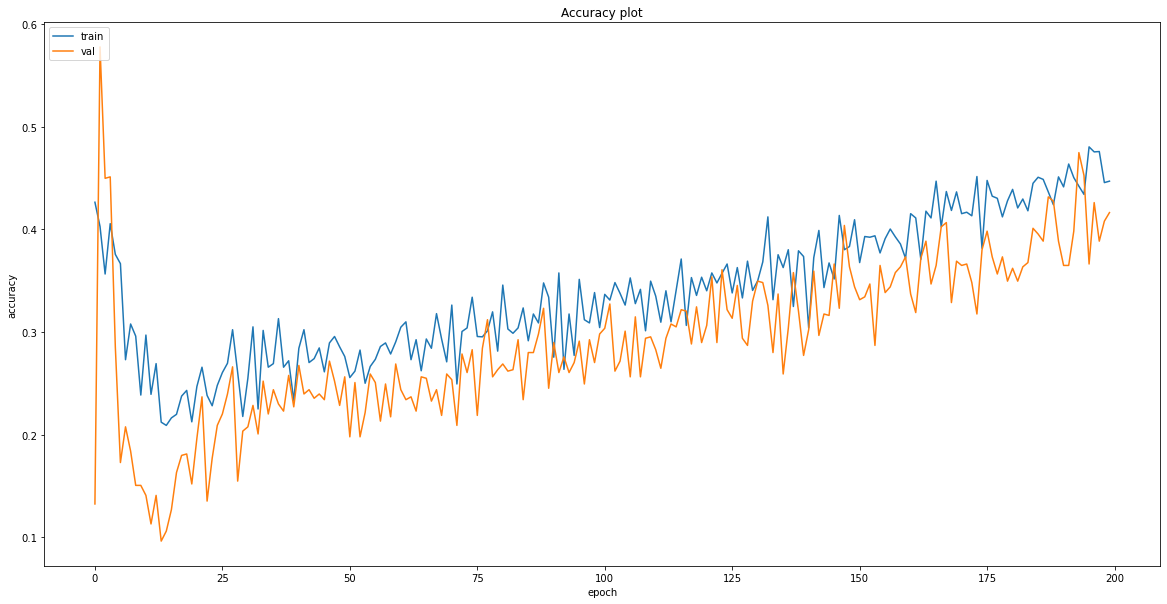

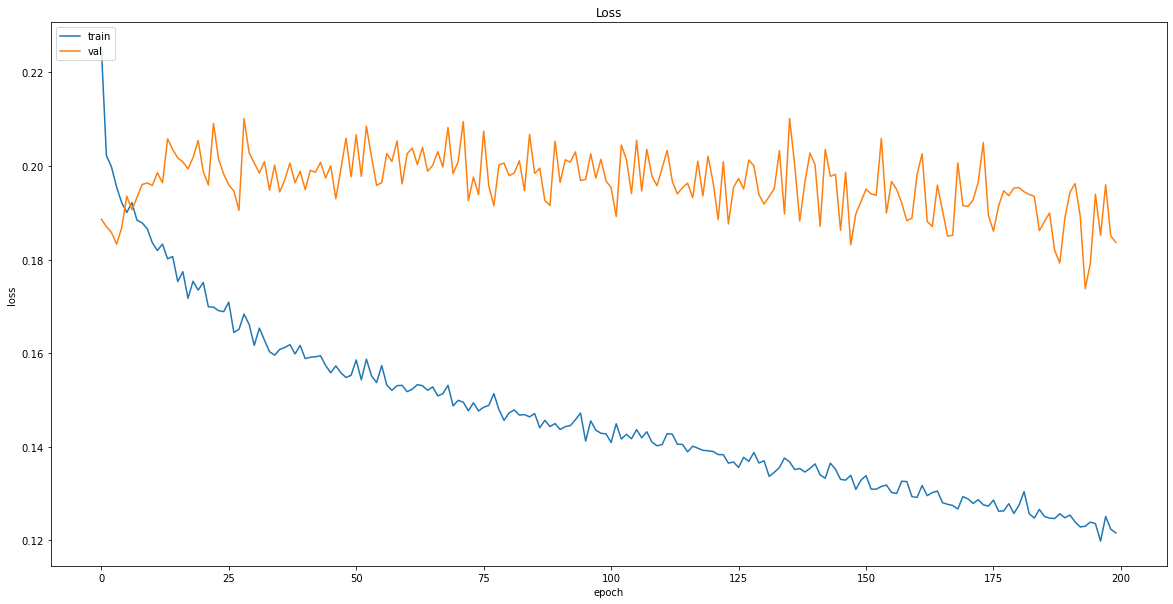

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# Save model
model.save("models/{}".format('cnooc_time_series_cnn_buy_hold_sell_original.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/cnooc_time_series_cnn_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [21]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


In [22]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [23]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [24]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [25]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [26]:
model = tf.keras.models.load_model("models/cnooc_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1921 - accuracy: 0.3555 - mean_squared_error: 2.4180 - weighted_accuracy: 0.3555 - weighted_mean_squared_error: 2.4180
Test loss: 0.19211535155773163
Test accuracy: 0.35545024275779724


In [27]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 65, 2: 77, 1: 69})

In [28]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [29]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [30]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-14        13.46  13.005887  -9.090899  594167146.0     2.0   
2019-02-15        13.28  13.075751  -2.222168  636062191.0     2.0   
2019-02-18        13.68  13.107174 -22.222210  601994876.0     2.0   
2019-02-19        13.76  13.195301 -15.384598  654106730.0     2.0   
2019-02-20        13.92  13.282178  -9.230759  687559434.0     2.0   

            predictions  actual  
Date                             
2019-02-14            0       2  
2019-02-15            0       2  
2019-02-18            2       2  
2019-02-19            0       2  
2019-02-20            2       2

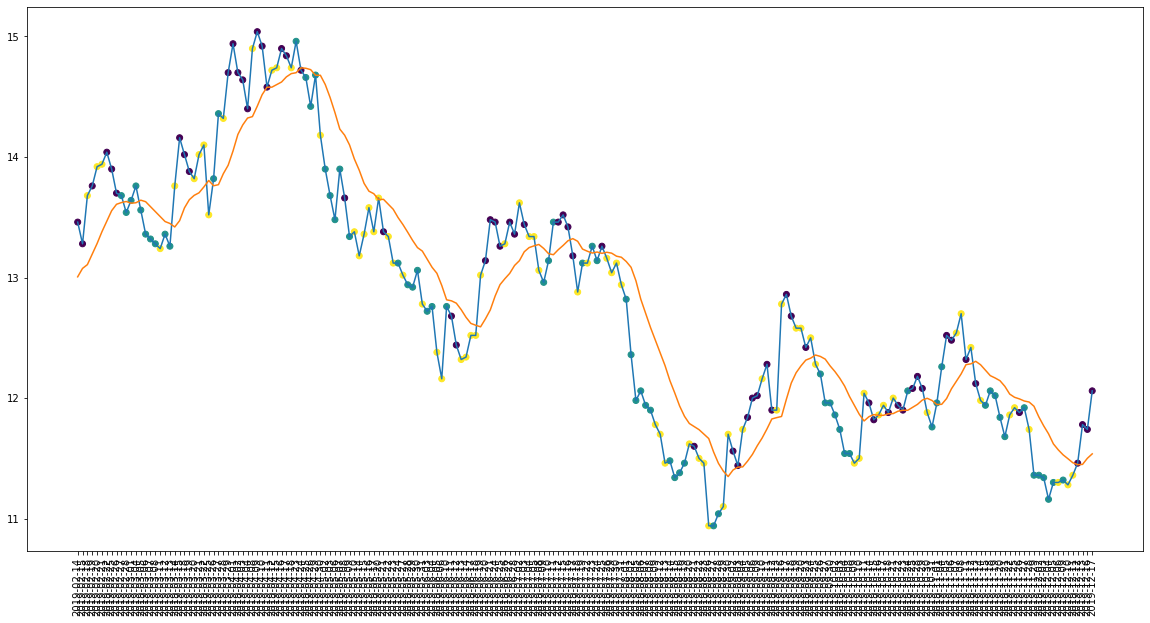

In [31]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

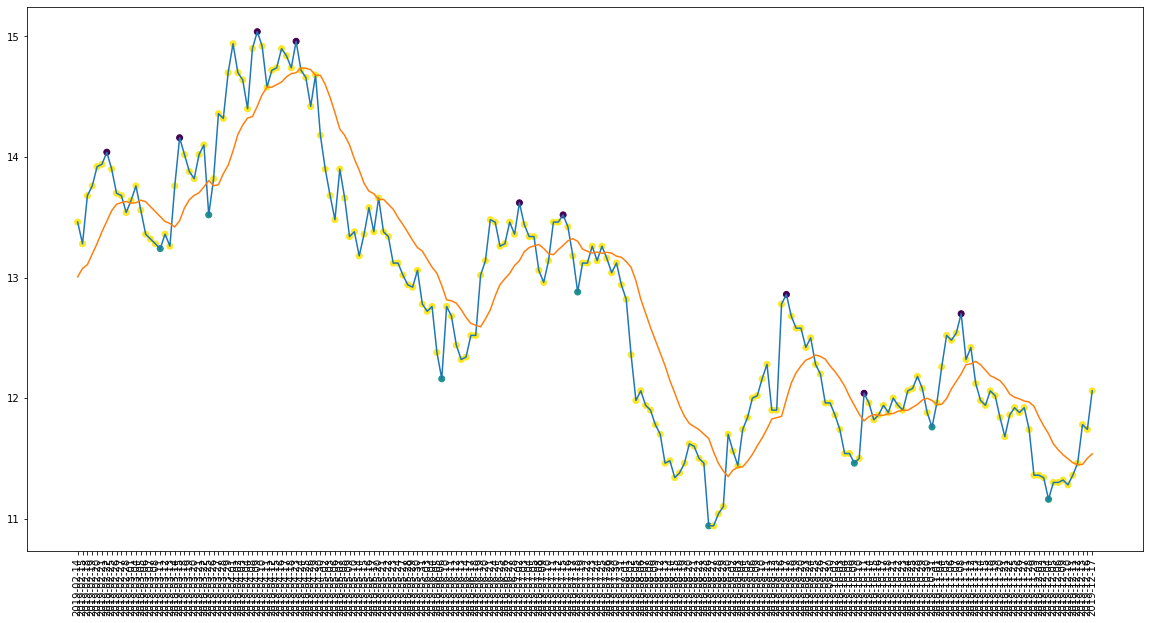

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 66
actual holds but predicted sell: 60
actual predicted holds: 68
Percentage buys correct: 25.0%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 35.05154639175258%
actual buys: 8
actual sells: 9
actual holds: 194


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 52.17391304347826%
Percentage sells correct: 60.9375%
Percentage holds correct: 83.11688311688312%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $13.279999732971193
Shares owned at the moment: 725
Cash capital at the moment: $0.3488574869643344


Price increase from previously bought: 6.334088276333438%
Share price: $14.15999984741211
Shares owned at the moment: 0
Cash capital at the moment: $10238.117247164966


Share price: $13.81999969482422
Shares owned at the moment: 738
Cash capital at the moment: $10.909783004044584


Price increase from previously bought: 6.075875523736918%
Share price: $14.699999809265135
Shares owned at the moment: 0
Cash capital at the moment: $10829.67599262881


Share price: $14.960000038146973
Shares owned at the moment: 721
Cash capital at the moment: $13.854025049207848


Stop Loss Activated!

Share price: $14.420000076293945
Shares owned 

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [37]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [38]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [39]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [40]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [41]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [42]:
model = tf.keras.models.load_model("models/cnooc_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1862 - accuracy: 0.4883 - mean_squared_error: 2.3654 - weighted_accuracy: 0.4883 - weighted_mean_squared_error: 2.3654
Test loss: 0.18615049123764038
Test accuracy: 0.48826292157173157


In [43]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 96, 1: 71, 0: 46})

In [44]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [45]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [46]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2020-02-13        12.34  12.385912 -50.526328  113135355.0     2.0   
2020-02-14        12.34  12.378849 -50.588221   60757697.0     2.0   
2020-02-17        12.26  12.372872 -46.153851   60757697.0     2.0   
2020-02-18        12.00  12.355507 -38.709648    5146960.0     2.0   
2020-02-19        12.08  12.300814 -59.677412  -52626865.0     2.0   

            predictions  actual  
Date                             
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            2       2  
2020-02-18            1       2  
2020-02-19            1       2

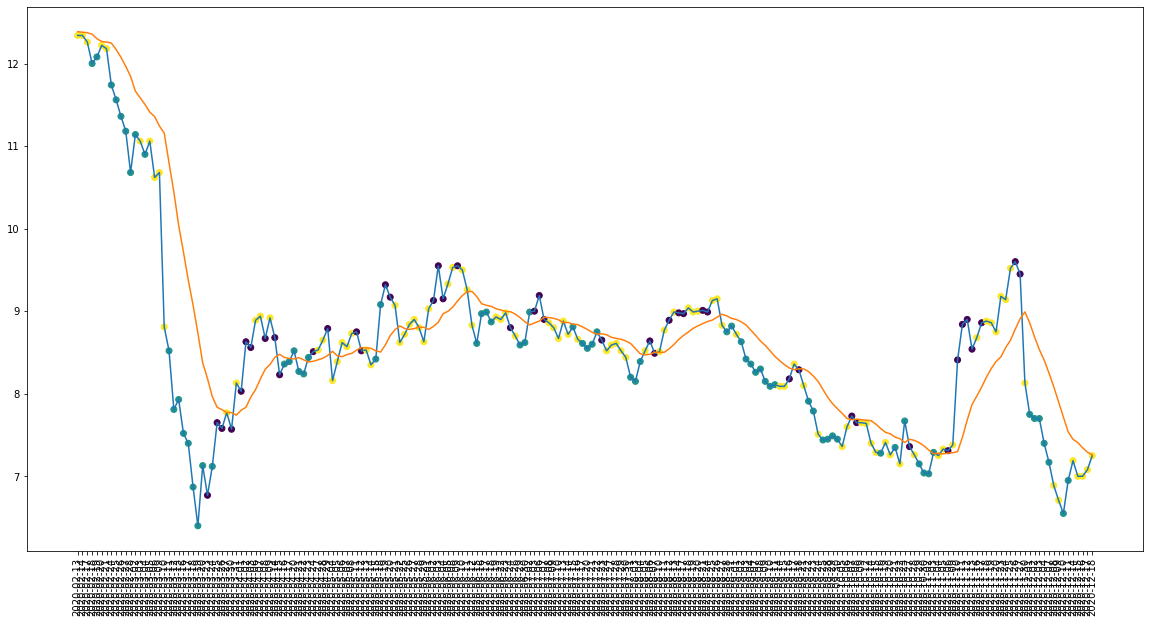

In [47]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

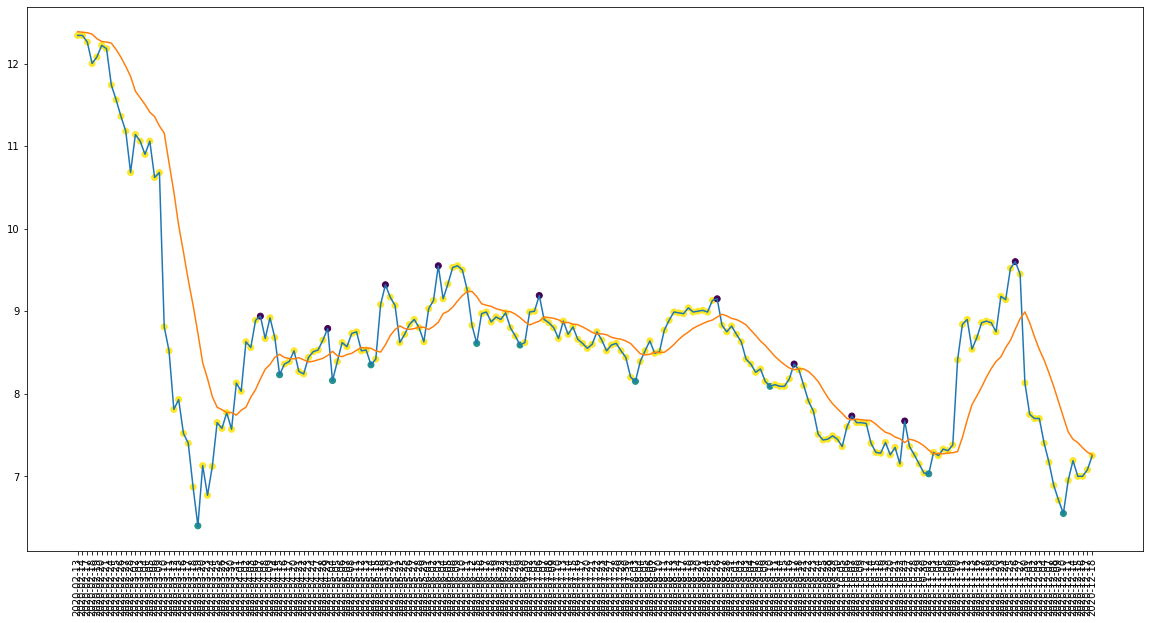

In [48]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [49]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 63
actual holds but predicted sell: 39
actual predicted holds: 91
Percentage buys correct: 70.0%
Percentage sells correct: 60.0%
Percentage holds correct: 47.15025906735751%
actual buys: 10
actual sells: 10
actual holds: 193


In [50]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 49.29577464788732%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 83.33333333333333%


In [51]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $12.0
Shares owned at the moment: 831
Cash capital at the moment: $0.5769999999993161


Stop Loss Activated!

Share price: $11.5600004196167
Shares owned at the moment: 0
Cash capital at the moment: $9580.519857742547


Share price: $11.5600004196167
Shares owned at the moment: 826
Cash capital at the moment: $5.700970185993356


Stop Loss Activated!

Share price: $11.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9214.985851567979


Share price: $11.18000030517578
Shares owned at the moment: 821
Cash capital at the moment: $10.96395532965289


Stop Loss Activated!

Share price: $10.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $8755.131435189956


Share price: $10.68000030517578
Shares owned at the moment: 817
Cash capital at the moment: $5.575895175690675


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7183.55236955976


Share price: $8.520000457763674
S

In [52]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [53]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


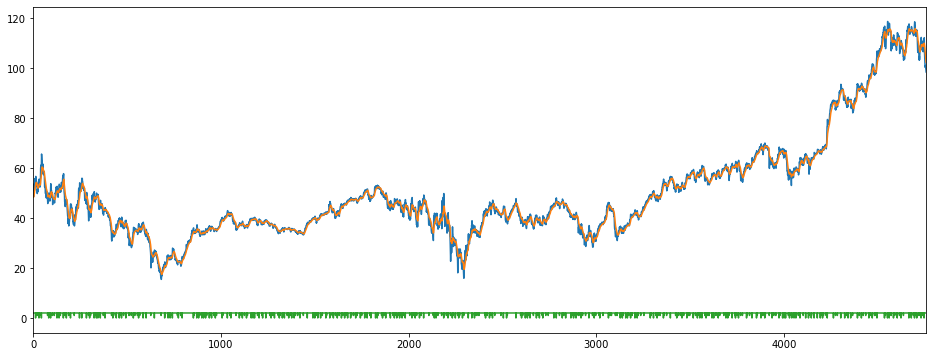

In [54]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [55]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0

In [56]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [57]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [58]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [59]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [60]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [61]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [64]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}
Epoch 1/200
30/30 [==============================] - 2s 83ms/step - loss: 0.2194 - accuracy: 0.4178 - mse: 0.9905 - weighted_accuracy: 0.3397 - weighted_mse: 1.0025 - val_loss: 0.1860 - val_accuracy: 0.5385 - val_mse: 1.1773 - val_weighted_accuracy: 0.5385 - val_weighted_mse: 1.1773
Epoch 2/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1998 - accuracy: 0.4023 - mse: 1.1687 - weighted_accuracy: 0.3784 - weighted_mse: 1.1630 - val_loss: 0.1894 - val_accuracy: 0.2392 - val_mse: 1.1416 - val_weighted_accuracy: 0.2392 - val_weighted_mse: 1.1416
Epoch 3/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1972 - accuracy: 0.3448 - mse: 1.1819 - weighted_accuracy: 0.4152 - weighted_mse: 1.1859 - val_loss: 0.1929 - val_accuracy: 0.1475 - val_mse: 1.0793 - val_weighted_accuracy: 0.1475 - val_weighted_mse: 1.0793
Epoch 4/200
30/30 [==============================] - 0s 13ms/step - loss: 0.19

Epoch 57/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1566 - accuracy: 0.2584 - mse: 1.7153 - weighted_accuracy: 0.6070 - weighted_mse: 1.5920 - val_loss: 0.1992 - val_accuracy: 0.2160 - val_mse: 1.5953 - val_weighted_accuracy: 0.2160 - val_weighted_mse: 1.5953
Epoch 58/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1545 - accuracy: 0.2492 - mse: 1.6301 - weighted_accuracy: 0.6303 - weighted_mse: 1.5611 - val_loss: 0.1999 - val_accuracy: 0.2107 - val_mse: 1.6356 - val_weighted_accuracy: 0.2107 - val_weighted_mse: 1.6356
Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1568 - accuracy: 0.2666 - mse: 1.7071 - weighted_accuracy: 0.5951 - weighted_mse: 1.6185 - val_loss: 0.1974 - val_accuracy: 0.2255 - val_mse: 1.5326 - val_weighted_accuracy: 0.2255 - val_weighted_mse: 1.5326
Epoch 60/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1558 - accuracy: 0.2837 - mse: 1.6539 - weighted_accuracy: 0.6201 - 

Epoch 86/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1487 - accuracy: 0.3074 - mse: 1.8008 - weighted_accuracy: 0.6500 - weighted_mse: 1.7261 - val_loss: 0.2019 - val_accuracy: 0.2497 - val_mse: 1.7688 - val_weighted_accuracy: 0.2497 - val_weighted_mse: 1.7688
Epoch 87/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1497 - accuracy: 0.2740 - mse: 1.8487 - weighted_accuracy: 0.6335 - weighted_mse: 1.7674 - val_loss: 0.2039 - val_accuracy: 0.2139 - val_mse: 1.7401 - val_weighted_accuracy: 0.2139 - val_weighted_mse: 1.7401
Epoch 88/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1517 - accuracy: 0.2690 - mse: 1.7781 - weighted_accuracy: 0.6414 - weighted_mse: 1.6906 - val_loss: 0.1994 - val_accuracy: 0.2287 - val_mse: 1.7361 - val_weighted_accuracy: 0.2287 - val_weighted_mse: 1.7361
Epoch 89/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1484 - accuracy: 0.2864 - mse: 1.7927 - weighted_accuracy: 0.6380 - 

Epoch 115/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1424 - accuracy: 0.3101 - mse: 1.9518 - weighted_accuracy: 0.6773 - weighted_mse: 1.9243 - val_loss: 0.1996 - val_accuracy: 0.2677 - val_mse: 1.8896 - val_weighted_accuracy: 0.2677 - val_weighted_mse: 1.8896
Epoch 116/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1418 - accuracy: 0.3348 - mse: 1.8970 - weighted_accuracy: 0.6766 - weighted_mse: 1.8427 - val_loss: 0.1989 - val_accuracy: 0.2719 - val_mse: 1.8748 - val_weighted_accuracy: 0.2719 - val_weighted_mse: 1.8748
Epoch 117/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1411 - accuracy: 0.3419 - mse: 1.9606 - weighted_accuracy: 0.6792 - weighted_mse: 1.9442 - val_loss: 0.2020 - val_accuracy: 0.2550 - val_mse: 1.8242 - val_weighted_accuracy: 0.2550 - val_weighted_mse: 1.8242
Epoch 118/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1397 - accuracy: 0.3222 - mse: 1.9320 - weighted_accuracy: 0.682

Epoch 144/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1353 - accuracy: 0.3641 - mse: 2.1421 - weighted_accuracy: 0.6796 - weighted_mse: 2.1150 - val_loss: 0.1884 - val_accuracy: 0.3477 - val_mse: 2.0033 - val_weighted_accuracy: 0.3477 - val_weighted_mse: 2.0033
Epoch 145/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1344 - accuracy: 0.3567 - mse: 2.1143 - weighted_accuracy: 0.7115 - weighted_mse: 2.1051 - val_loss: 0.1917 - val_accuracy: 0.3319 - val_mse: 2.1543 - val_weighted_accuracy: 0.3319 - val_weighted_mse: 2.1543
Epoch 146/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1330 - accuracy: 0.3699 - mse: 2.1651 - weighted_accuracy: 0.7144 - weighted_mse: 2.1855 - val_loss: 0.1995 - val_accuracy: 0.3014 - val_mse: 2.0821 - val_weighted_accuracy: 0.3014 - val_weighted_mse: 2.0821
Epoch 147/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1342 - accuracy: 0.3920 - mse: 2.1710 - weighted_accuracy: 0.715

Epoch 173/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1250 - accuracy: 0.4270 - mse: 2.3925 - weighted_accuracy: 0.7527 - weighted_mse: 2.5144 - val_loss: 0.1841 - val_accuracy: 0.3973 - val_mse: 2.2660 - val_weighted_accuracy: 0.3973 - val_weighted_mse: 2.2660
Epoch 174/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1256 - accuracy: 0.4349 - mse: 2.3887 - weighted_accuracy: 0.7551 - weighted_mse: 2.4509 - val_loss: 0.1960 - val_accuracy: 0.3551 - val_mse: 2.2798 - val_weighted_accuracy: 0.3551 - val_weighted_mse: 2.2798
Epoch 175/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1245 - accuracy: 0.4386 - mse: 2.3713 - weighted_accuracy: 0.7607 - weighted_mse: 2.4445 - val_loss: 0.1880 - val_accuracy: 0.3878 - val_mse: 2.2903 - val_weighted_accuracy: 0.3878 - val_weighted_mse: 2.2903
Epoch 176/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1238 - accuracy: 0.4289 - mse: 2.4653 - weighted_accuracy: 0.745

In [65]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20385794341564178
Test accuracy: 0.36143308877944946


In [66]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.90381175 -0.8778294  -0.45945004]
 [-1.5879326  -1.6591538   0.08827155]
 [-0.92006975 -1.8464948  -0.08044669]
 ...
 [-1.0186479  -1.5463418  -0.06684717]
 [ 0.29098    -2.2504544  -0.8460205 ]
 [-0.10012969 -1.8758496  -0.6072301 ]]


Counter({2: 317, 0: 330, 1: 302})

In [67]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [68]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 26
actual buys but predicted sell: 3
actual buys but predicted hold: 14
actual sells but predicted buy: 5
actual predicted sells: 25
actual sells but predicted hold: 11
actual holds but predicted buy: 271
actual holds but predicted sell: 302
actual predicted holds: 292
Percentage buys correct: 60.46511627906977%
Percentage sells correct: 60.97560975609756%
Percentage holds correct: 33.75722543352601%
actual buys: 43
actual sells: 41
actual holds: 865


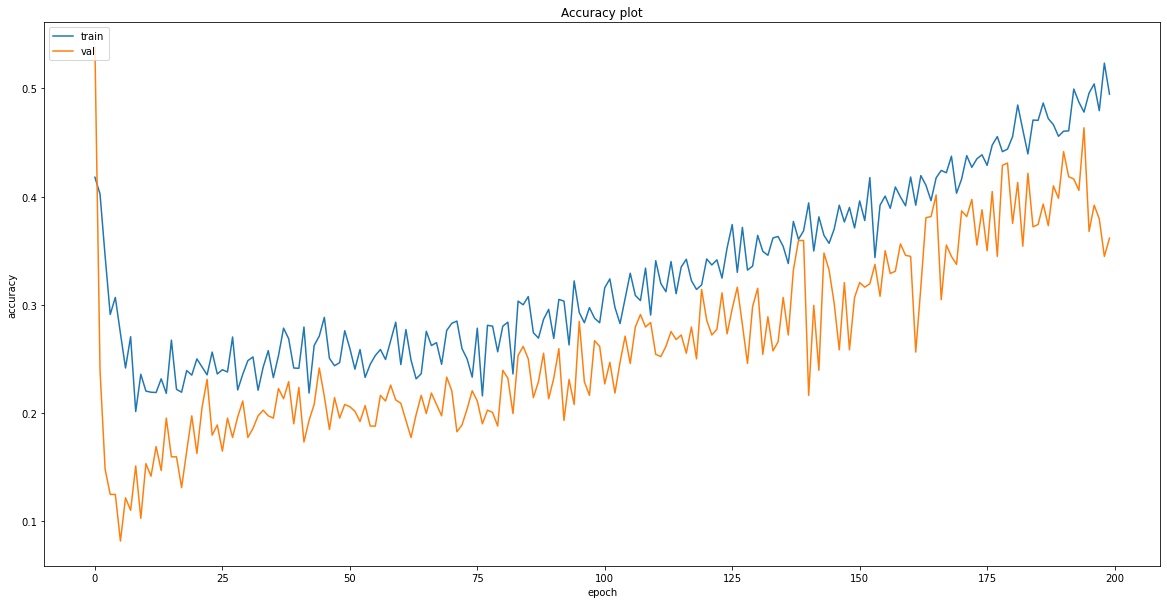

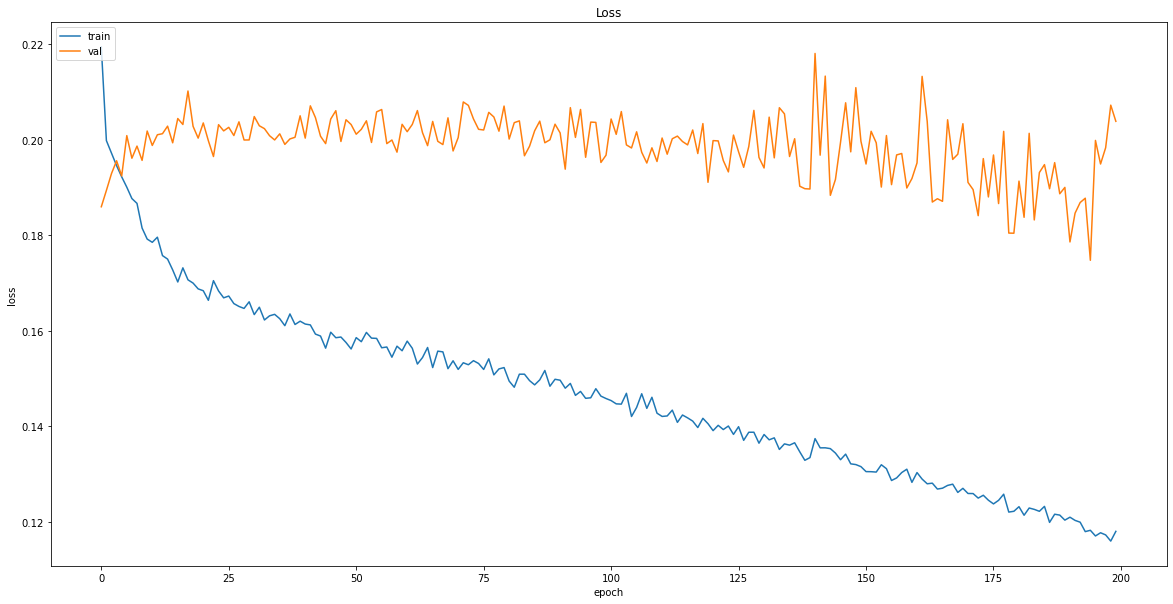

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
# Save model
model.save("models/{}".format('jpm_time_series_cnn_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_cnn_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [71]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [72]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [73]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [74]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [75]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [76]:
model = tf.keras.models.load_model("models/jpm_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 9ms/step - loss: 0.1997 - accuracy: 0.3807 - mean_squared_error: 2.5220 - weighted_accuracy: 0.3807 - weighted_mean_squared_error: 2.5220
Test loss: 0.19974826276302338
Test accuracy: 0.3807339370250702


In [77]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 61, 2: 74, 0: 83})

In [78]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [79]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [80]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-11   100.879997  102.975915 -74.903417  73097300.0     1.0   
2019-02-12   102.599998  102.653466 -84.169891  62118800.0     2.0   
2019-02-13   103.089996  102.645240 -50.965236  74971100.0     2.0   
2019-02-14   102.419998  102.713664 -41.505819  85725200.0     2.0   
2019-02-15   105.550003  102.668485 -54.440145  74206700.0     2.0   

            predictions  actual  
Date                             
2019-02-11            1       1  
2019-02-12            1       2  
2019-02-13            1       2  
2019-02-14            2       2  
2019-02-15            2       2

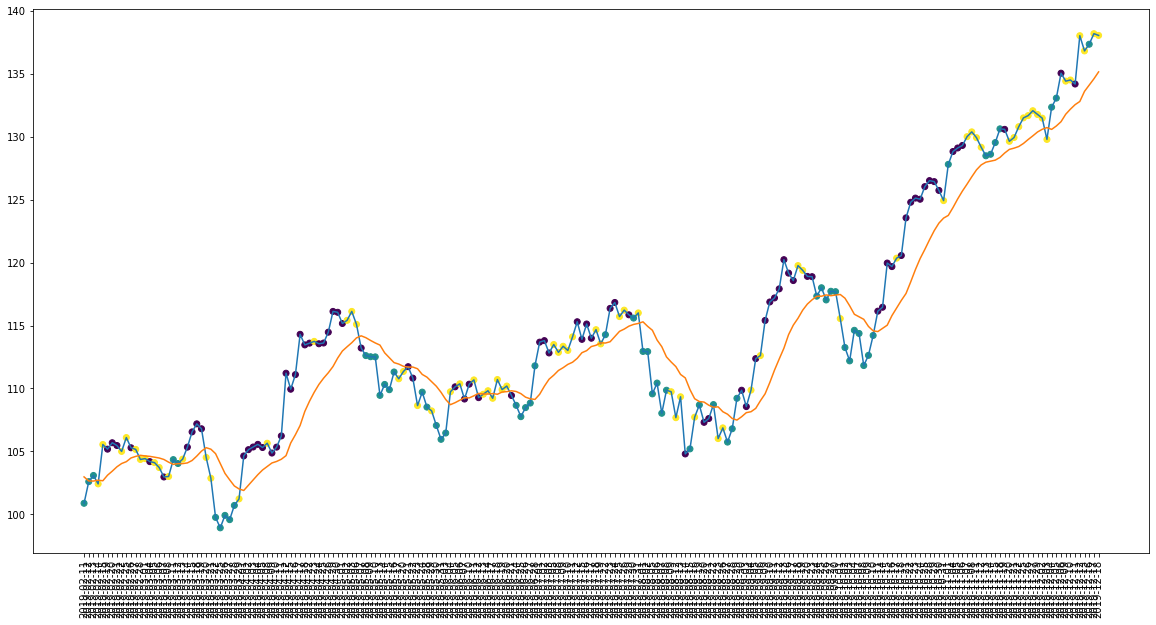

In [81]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

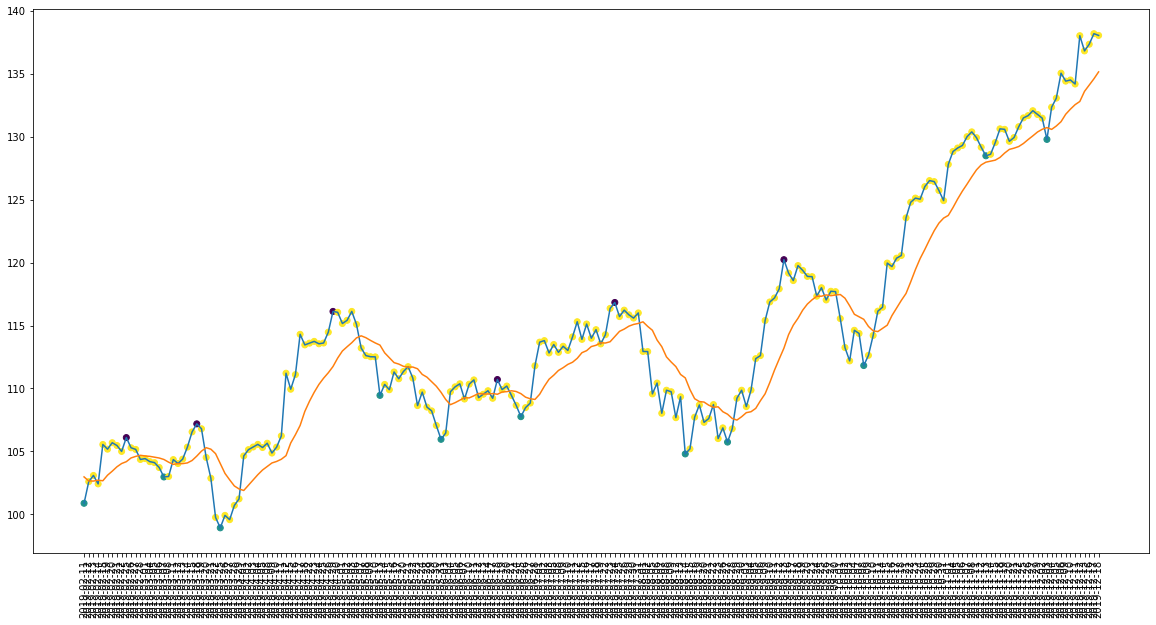

In [82]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [83]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 53
actual holds but predicted sell: 77
actual predicted holds: 71
Percentage buys correct: 72.72727272727273%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 35.32338308457712%
actual buys: 11
actual sells: 6
actual holds: 201


In [84]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 59.01639344262295%
Percentage sells correct: 46.34146341463415%
Percentage holds correct: 85.13513513513513%


In [85]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $100.87999725341795
Shares owned at the moment: 98
Cash capital at the moment: $86.57310990524456


Price increase from previously bought: 5.330885220987969%
Share price: $106.5500030517578
Shares owned at the moment: 0
Cash capital at the moment: $10499.75818315506


Share price: $99.76000213623048
Shares owned at the moment: 104
Cash capital at the moment: $96.18660037612608


Price increase from previously bought: 5.1039044574216375%
Share price: $105.13999938964844
Shares owned at the moment: 0
Cash capital at the moment: $11000.676497074124


Share price: $112.61000061035156
Shares owned at the moment: 97
Cash capital at the moment: $47.46772020721073


Stop Loss Activated!

Share price: $109.4499969482422
Shares owned at the moment: 0
Cash capital at the moment: $10634.92163750076


Share price: $109.4499969482422
Shares owned at the moment: 96
Cash capital at the moment: $98.82713127517127


Stop Loss Activated!

Share price: $105.95999908447266
Shares owned at the 

In [86]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [87]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [88]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [89]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [90]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [91]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [92]:
model = tf.keras.models.load_model("models/jpm_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1900 - accuracy: 0.3881 - mean_squared_error: 2.4057 - weighted_accuracy: 0.3881 - weighted_mean_squared_error: 2.4057
Test loss: 0.1899857074022293
Test accuracy: 0.388127863407135


In [93]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 83, 0: 75, 1: 61})

In [94]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [95]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [96]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   138.000000  136.179383  -6.410124  26757600.0     0.0   
2020-02-12   138.000000  136.459478  -9.001177  33336200.0     2.0   
2020-02-13   137.880005  136.696481 -13.465502  33336200.0     2.0   
2020-02-14   137.460007  136.878562 -14.718062  25888700.0     2.0   
2020-02-18   135.639999  136.968015 -23.401387  19261100.0     2.0   

            predictions  actual  
Date                             
2020-02-11            2       0  
2020-02-12            2       2  
2020-02-13            0       2  
2020-02-14            0       2  
2020-02-18            0       2

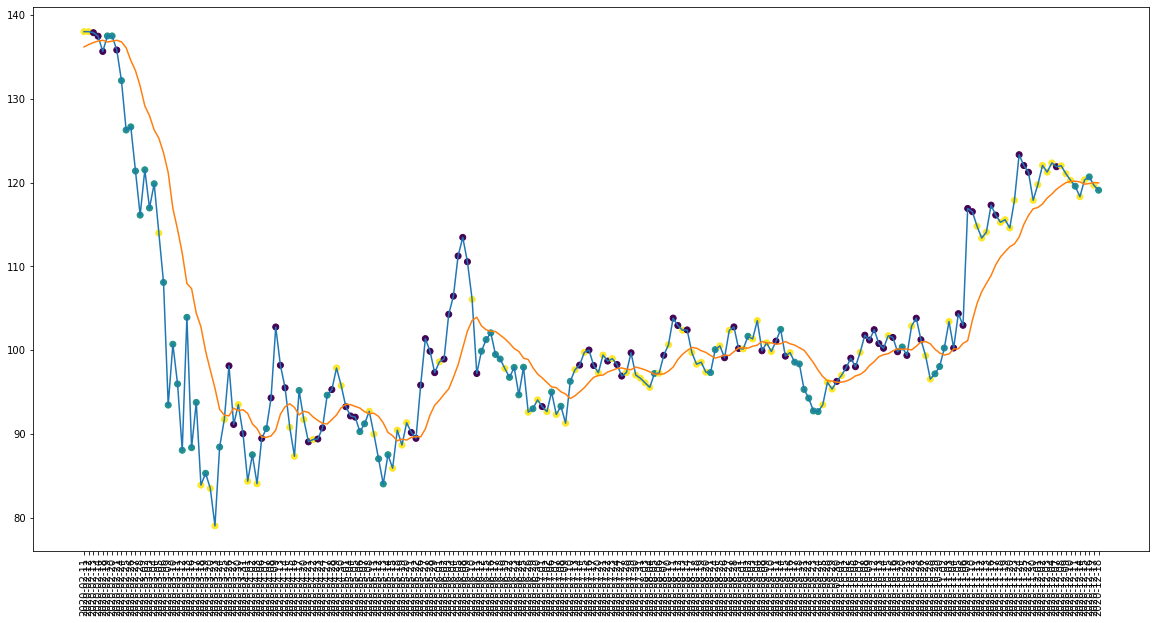

In [97]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

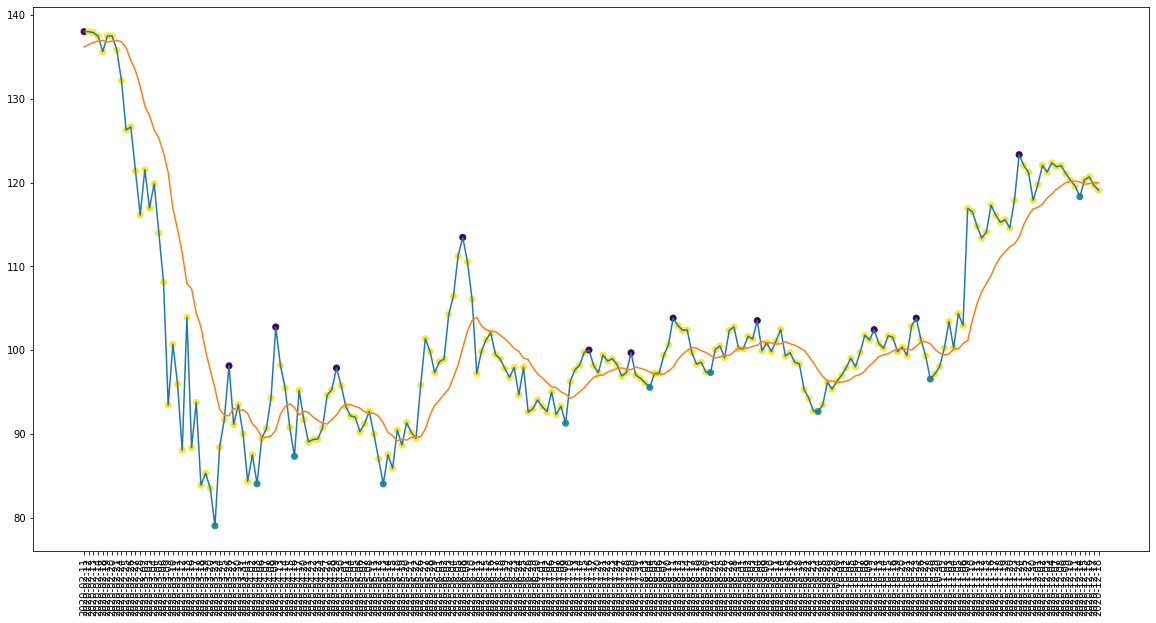

In [98]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [99]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 3
actual holds but predicted buy: 58
actual holds but predicted sell: 66
actual predicted holds: 73
Percentage buys correct: 30.0%
Percentage sells correct: 75.0%
Percentage holds correct: 37.055837563451774%
actual buys: 10
actual sells: 12
actual holds: 197


In [100]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 40.0%
Percentage sells correct: 53.333333333333336%
Percentage holds correct: 80.72289156626506%


In [101]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $137.49000549316406
Shares owned at the moment: 72
Cash capital at the moment: $73.49658340454152


Stop Loss Activated!

Share price: $132.16000366210938
Shares owned at the moment: 0
Cash capital at the moment: $9562.849166351318


Share price: $132.16000366210938
Shares owned at the moment: 72
Cash capital at the moment: $21.161221954344


Stop Loss Activated!

Share price: $126.26000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9086.881895339966


Share price: $126.26000213623048
Shares owned at the moment: 71
Cash capital at the moment: $97.76947825050229


Stop Loss Activated!

Share price: $121.37000274658205
Shares owned at the moment: 0
Cash capital at the moment: $8691.342180221558


Share price: $121.37000274658205
Shares owned at the moment: 71
Cash capital at the moment: $50.374492177961656


Stop Loss Activated!

Share price: $116.11000061035156
Shares owned at the moment: 0
Cash capital at the moment: $8271.514057893752


Share price: 

In [102]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [4]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


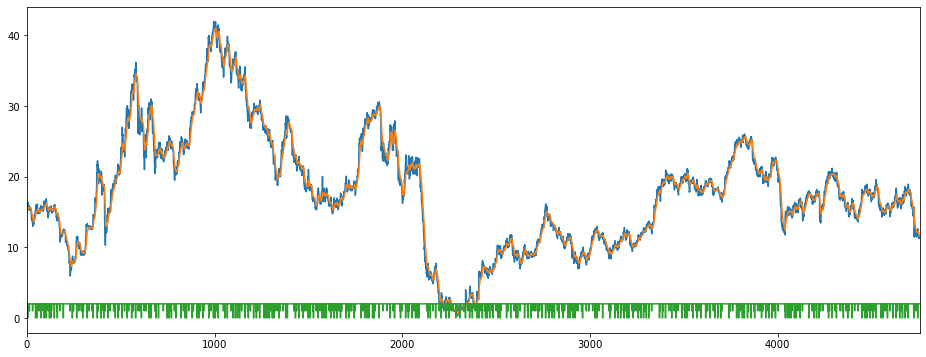

In [5]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [6]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0

In [7]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [8]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [9]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [10]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [12]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.3140655105973025, 2: 0.36686962404561707}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.2593 - accuracy: 0.7031 - mse: 0.4289 - weighted_accuracy: 0.3248 - weighted_mse: 0.5578WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 23ms/step - loss: 0.2213 - accuracy: 0.4594 - mse: 0.9799 - weighted_accuracy: 0.3478 - weighted_mse: 1.0199 - val_loss: 0.1855 - val_accuracy: 0.2339 - val_mse: 1.1983 - val_weighted_accuracy: 0.2339 - val_weighted_mse: 1.1983
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2029 - accuracy: 0.3786 - mse: 1.1364 - weighted_accuracy: 0.3707 - weighted_mse: 1.1537 - val_loss: 0.1893 - val_accuracy: 0.3509 - v

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1711 - accuracy: 0.2334 - mse: 1.4148 - weighted_accuracy: 0.5728 - weighted_mse: 1.3259 - val_loss: 0.1990 - val_accuracy: 0.1791 - val_mse: 1.3348 - val_weighted_accuracy: 0.1791 - val_weighted_mse: 1.3348
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1706 - accuracy: 0.2210 - mse: 1.4162 - weighted_accuracy: 0.5610 - weighted_mse: 1.3185 - val_loss: 0.2060 - val_accuracy: 0.1528 - val_mse: 1.3554 - val_weighted_accuracy: 0.1528 - val_weighted_mse: 1.3554
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1684 - accuracy: 0.2089 - mse: 1.4073 - weighted_accuracy: 0.5766 - weighted_mse: 1.3212 - val_loss: 0.2018 - val_accuracy: 0.1549 - val_mse: 1.4057 - val_weighted_accuracy: 0.1549 - val_weighted_mse: 1.4057
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1704 - accuracy: 0.2052 - mse: 1.4346 - weighted_accuracy: 0.5625 - weig

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1584 - accuracy: 0.2582 - mse: 1.6285 - weighted_accuracy: 0.5892 - weighted_mse: 1.5327 - val_loss: 0.2050 - val_accuracy: 0.2013 - val_mse: 1.4897 - val_weighted_accuracy: 0.2013 - val_weighted_mse: 1.4897
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1608 - accuracy: 0.2210 - mse: 1.5637 - weighted_accuracy: 0.6212 - weighted_mse: 1.4623 - val_loss: 0.2026 - val_accuracy: 0.1981 - val_mse: 1.5298 - val_weighted_accuracy: 0.1981 - val_weighted_mse: 1.5298
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1592 - accuracy: 0.2405 - mse: 1.6003 - weighted_accuracy: 0.5954 - weighted_mse: 1.5187 - val_loss: 0.1986 - val_accuracy: 0.2171 - val_mse: 1.4932 - val_weighted_accuracy: 0.2171 - val_weighted_mse: 1.4932
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1587 - accuracy: 0.2516 - mse: 1.5827 - weighted_accuracy: 0.6196 - weig

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1503 - accuracy: 0.2426 - mse: 1.8061 - weighted_accuracy: 0.6437 - weighted_mse: 1.7106 - val_loss: 0.1972 - val_accuracy: 0.2508 - val_mse: 1.6550 - val_weighted_accuracy: 0.2508 - val_weighted_mse: 1.6550
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1517 - accuracy: 0.2663 - mse: 1.7314 - weighted_accuracy: 0.6542 - weighted_mse: 1.6289 - val_loss: 0.2033 - val_accuracy: 0.2308 - val_mse: 1.7243 - val_weighted_accuracy: 0.2308 - val_weighted_mse: 1.7243
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1506 - accuracy: 0.2658 - mse: 1.7463 - weighted_accuracy: 0.6467 - weighted_mse: 1.6571 - val_loss: 0.1969 - val_accuracy: 0.2508 - val_mse: 1.6393 - val_weighted_accuracy: 0.2508 - val_weighted_mse: 1.6393
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1513 - accuracy: 0.2634 - mse: 1.7509 - weighted_accuracy: 0.6477 - weig

Epoch 114/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1443 - accuracy: 0.2987 - mse: 1.8735 - weighted_accuracy: 0.6825 - weighted_mse: 1.8020 - val_loss: 0.1974 - val_accuracy: 0.2866 - val_mse: 1.8659 - val_weighted_accuracy: 0.2866 - val_weighted_mse: 1.8659
Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1453 - accuracy: 0.3019 - mse: 1.9390 - weighted_accuracy: 0.6655 - weighted_mse: 1.8622 - val_loss: 0.1984 - val_accuracy: 0.2476 - val_mse: 1.7792 - val_weighted_accuracy: 0.2476 - val_weighted_mse: 1.7792
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1447 - accuracy: 0.2879 - mse: 1.8214 - weighted_accuracy: 0.6658 - weighted_mse: 1.7705 - val_loss: 0.1955 - val_accuracy: 0.2708 - val_mse: 1.7789 - val_weighted_accuracy: 0.2708 - val_weighted_mse: 1.7789
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1450 - accuracy: 0.2921 - mse: 1.8352 - weighted_accuracy: 0.6856 - 

Epoch 143/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1380 - accuracy: 0.3211 - mse: 2.0227 - weighted_accuracy: 0.7053 - weighted_mse: 1.9697 - val_loss: 0.1981 - val_accuracy: 0.2845 - val_mse: 1.9492 - val_weighted_accuracy: 0.2845 - val_weighted_mse: 1.9492
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1388 - accuracy: 0.3195 - mse: 2.0688 - weighted_accuracy: 0.6865 - weighted_mse: 2.0144 - val_loss: 0.1954 - val_accuracy: 0.3003 - val_mse: 2.0048 - val_weighted_accuracy: 0.3003 - val_weighted_mse: 2.0048
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1375 - accuracy: 0.3440 - mse: 2.0337 - weighted_accuracy: 0.7101 - weighted_mse: 1.9899 - val_loss: 0.1947 - val_accuracy: 0.3077 - val_mse: 1.9885 - val_weighted_accuracy: 0.3077 - val_weighted_mse: 1.9885
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1369 - accuracy: 0.3612 - mse: 2.0181 - weighted_accuracy: 0.7000 - 

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1317 - accuracy: 0.3696 - mse: 2.1598 - weighted_accuracy: 0.7213 - weighted_mse: 2.1968 - val_loss: 0.1935 - val_accuracy: 0.3551 - val_mse: 2.1696 - val_weighted_accuracy: 0.3551 - val_weighted_mse: 2.1696
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1308 - accuracy: 0.4089 - mse: 2.2133 - weighted_accuracy: 0.7339 - weighted_mse: 2.2059 - val_loss: 0.1949 - val_accuracy: 0.3498 - val_mse: 2.1666 - val_weighted_accuracy: 0.3498 - val_weighted_mse: 2.1666
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1294 - accuracy: 0.4099 - mse: 2.1879 - weighted_accuracy: 0.7287 - weighted_mse: 2.2382 - val_loss: 0.1885 - val_accuracy: 0.3846 - val_mse: 2.1945 - val_weighted_accuracy: 0.3846 - val_weighted_mse: 2.1945
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1308 - accuracy: 0.4110 - mse: 2.2173 - weighted_accuracy: 0.7292 - 

In [13]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1928606629371643
Test accuracy: 0.3951528072357178


In [14]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.094091   -0.3418431  -0.42468843]
 [-0.20346984 -2.067039   -0.53742754]
 [-3.3795958  -0.10379728 -0.76688296]
 ...
 [-0.6993771  -1.1062452  -0.4742411 ]
 [-0.11102337 -1.9367955  -0.60969543]
 [-1.3718271  -1.6189232  -0.13133323]]


Counter({1: 335, 0: 275, 2: 339})

In [15]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [16]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 32
actual buys but predicted sell: 5
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 26
actual sells but predicted hold: 15
actual holds but predicted buy: 301
actual holds but predicted sell: 244
actual predicted holds: 317
Percentage buys correct: 72.72727272727273%
Percentage sells correct: 60.46511627906977%
Percentage holds correct: 36.774941995359626%
actual buys: 44
actual sells: 43
actual holds: 862


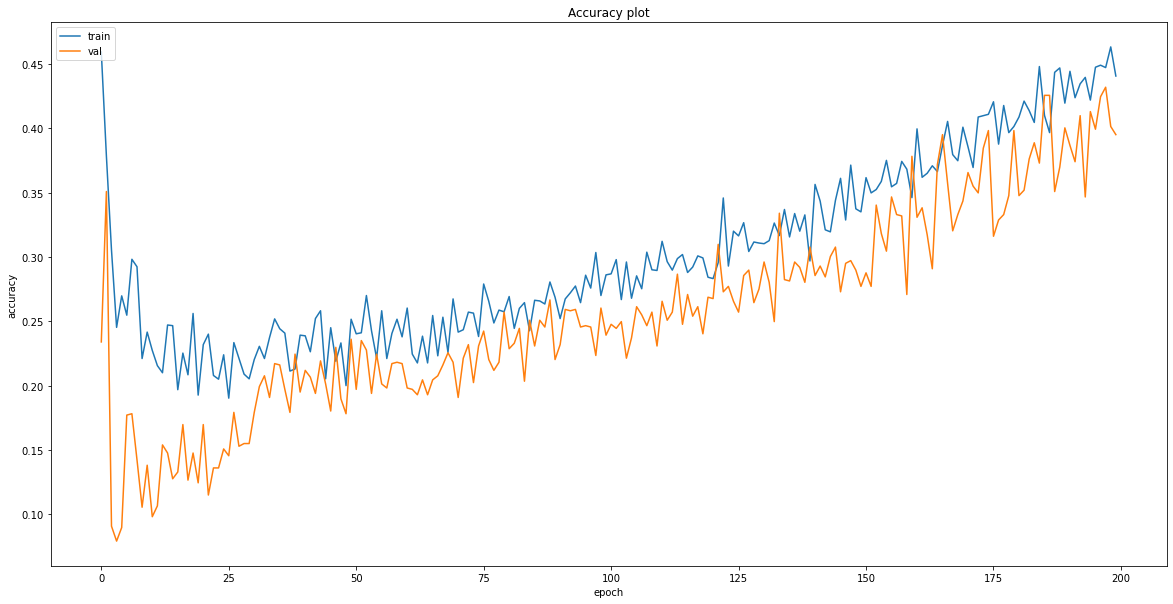

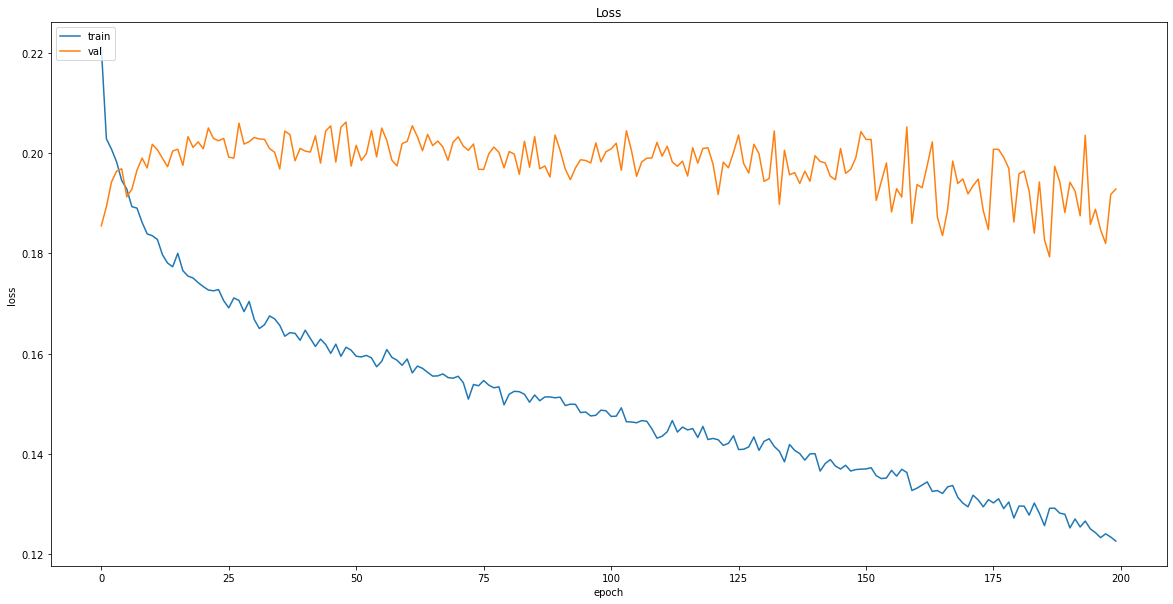

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
# Save model
model.save("models/{}".format('axl_time_series_cnn_buy_hold_sell_original.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/axl_time_series_cnn_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [19]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [20]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [21]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [22]:
model = tf.keras.models.load_model("models/axl_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1950 - accuracy: 0.3624 - mean_squared_error: 2.2468 - weighted_accuracy: 0.3624 - weighted_mean_squared_error: 2.2468
Test loss: 0.19495606422424316
Test accuracy: 0.3623853325843811


In [23]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 87, 2: 76, 0: 55})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [25]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [26]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        14.01  14.312907 -83.060094  17347800.0     2.0   
2019-02-12        14.34  14.266306 -68.852439  19189100.0     2.0   
2019-02-13        14.45  14.277643 -50.819664  21493700.0     2.0   
2019-02-14        14.70  14.304160 -44.808757  23008200.0     2.0   
2019-02-15        16.83  14.365058 -31.147561  25735200.0     2.0   

            predictions  actual  
Date                             
2019-02-11            1       2  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            0       2

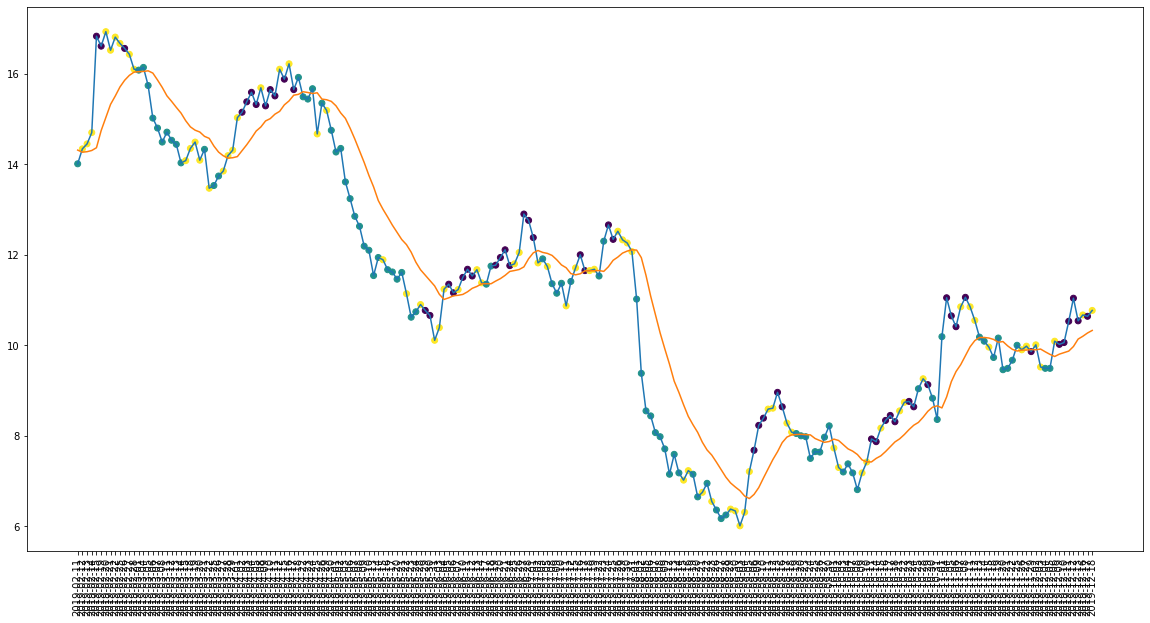

In [27]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

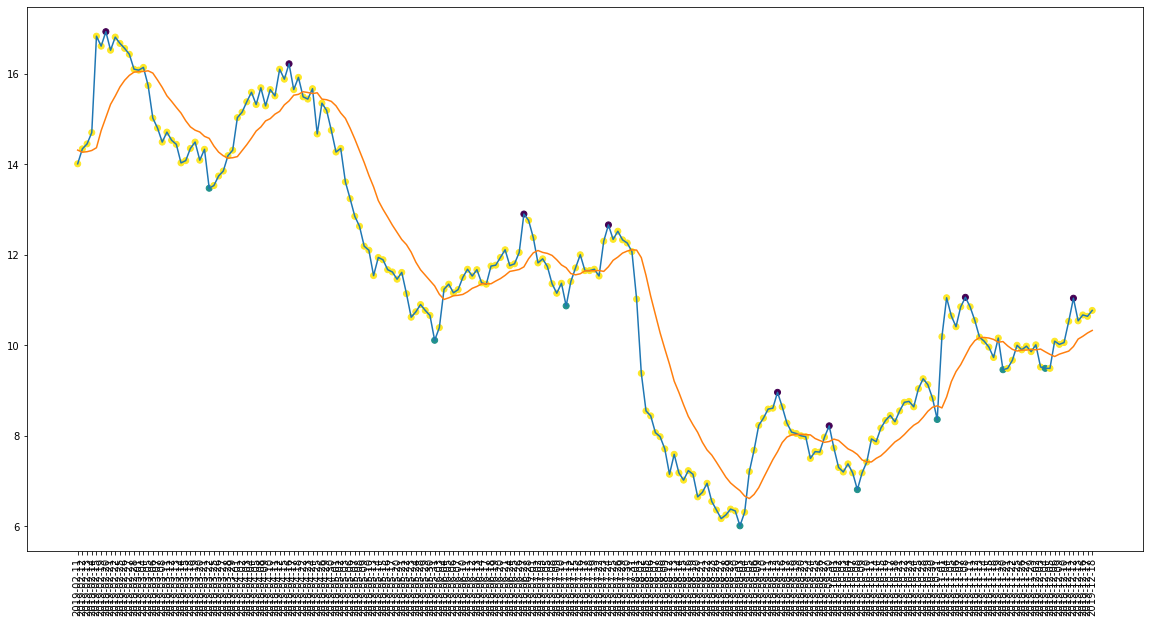

In [28]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [29]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 82
actual holds but predicted sell: 50
actual predicted holds: 70
Percentage buys correct: 50.0%
Percentage sells correct: 62.5%
Percentage holds correct: 34.65346534653465%
actual buys: 8
actual sells: 8
actual holds: 202


In [30]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 44.827586206896555%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 86.84210526315789%


In [31]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.010000228881836
Shares owned at the moment: 711
Cash capital at the moment: $11.496784317492711


Price increase from previously bought: 19.799029818276615%
Share price: $16.829999923706055
Shares owned at the moment: 0
Cash capital at the moment: $11944.719872721671


Share price: $16.079999923706055
Shares owned at the moment: 740
Cash capital at the moment: $12.797129334448982


Stop Loss Activated!

Share price: $15.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $11097.031767148017


Share price: $15.020000457763672
Shares owned at the moment: 736
Cash capital at the moment: $11.910949307441115


Stop Loss Activated!

Share price: $14.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10647.223021313666


Share price: $14.489999771118164
Shares owned at the moment: 732
Cash capital at the moment: $11.374819315909917


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital 

In [32]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [33]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [34]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [35]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [36]:
model = tf.keras.models.load_model("models/axl_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1914 - accuracy: 0.4201 - mean_squared_error: 2.2714 - weighted_accuracy: 0.4201 - weighted_mean_squared_error: 2.2714
Test loss: 0.19136333465576172
Test accuracy: 0.42009133100509644


In [37]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 81, 0: 67, 1: 71})

In [38]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [39]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [40]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-11         9.84  9.643918 -57.638900 -3274300.0     2.0            2   
2020-02-12        10.34  9.674085 -36.805548 -1876100.0     0.0            0   
2020-02-13        10.22  9.776533 -16.568036  -291400.0     2.0            0   
2020-02-14         8.77  9.844759 -23.668622 -1567700.0     2.0            0   
2020-02-18         8.27  9.679411 -90.686248 -6644000.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       0  
2020-02-13       2  
2020-02-14       2  
2020-02-18       2

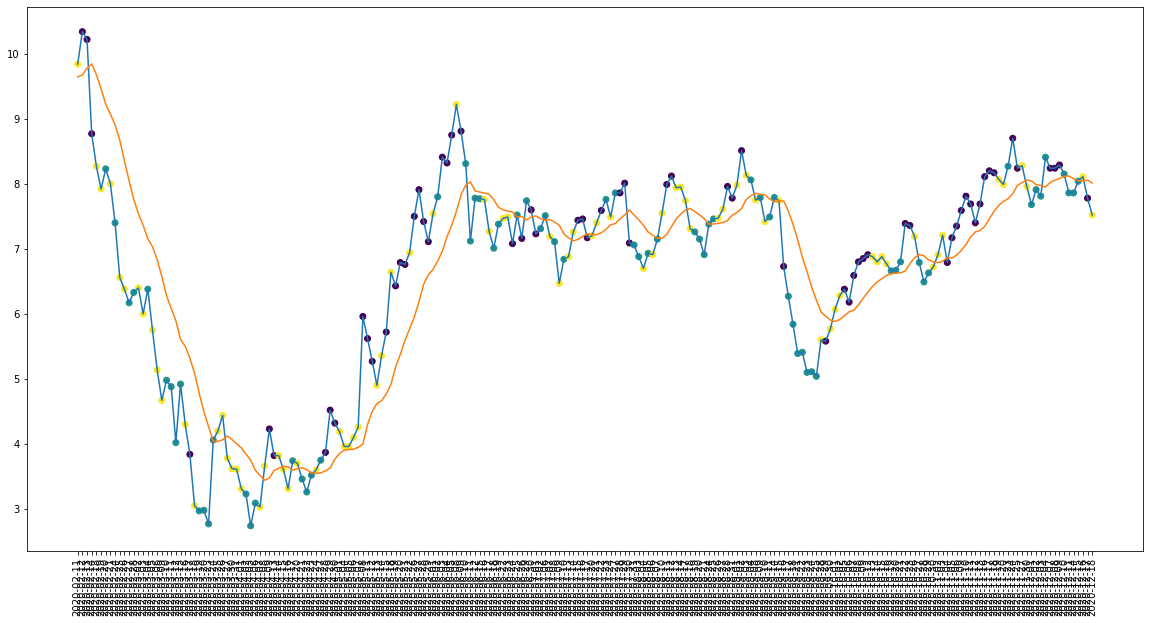

In [41]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

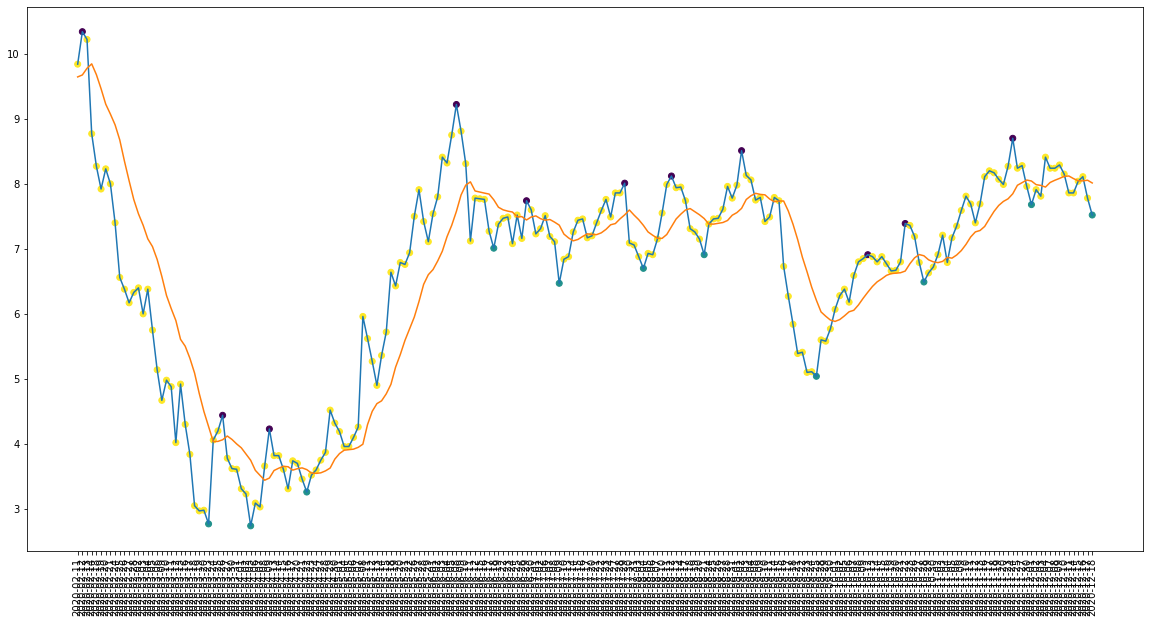

In [42]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [43]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 62
actual holds but predicted sell: 59
actual predicted holds: 76
Percentage buys correct: 72.72727272727273%
Percentage sells correct: 72.72727272727273%
Percentage holds correct: 38.578680203045685%
actual buys: 11
actual sells: 11
actual holds: 197


In [44]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 53.521126760563384%
Percentage sells correct: 62.6865671641791%
Percentage holds correct: 91.25%


In [45]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.229999542236326
Shares owned at the moment: 1211
Cash capital at the moment: $6.062598376274764


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9667.420598376275


Share price: $7.400000095367432
Shares owned at the moment: 1302
Cash capital at the moment: $6.124773866415126


Stop Loss Activated!

Share price: $6.559999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8523.756619570255


Share price: $6.170000076293945
Shares owned at the moment: 1377
Cash capital at the moment: $4.302266724585934


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $8243.581766724586


Share price: $6.380000114440918
Shares owned at the moment: 1288
Cash capital at the moment: $3.5436589193341206


Stop Loss Activated!

Share price: $5.75
Shares owned at the moment: 0
Cash capital at the moment: $7389.177158919334


Share price: $4.980000019073486
Shares owned at the 

In [46]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
